In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 29:55 - loss: 2.3981

  2/146 [..............................] - ETA: 8s - loss: 2.3977   

  3/146 [..............................] - ETA: 8s - loss: 2.3971

  4/146 [..............................] - ETA: 8s - loss: 2.3964

  5/146 [>.............................] - ETA: 8s - loss: 2.3956

  6/146 [>.............................] - ETA: 8s - loss: 2.3947

  7/146 [>.............................] - ETA: 8s - loss: 2.3935



  8/146 [>.............................] - ETA: 8s - loss: 2.3920

  9/146 [>.............................] - ETA: 8s - loss: 2.3904

 10/146 [=>............................] - ETA: 8s - loss: 2.3883

 11/146 [=>............................] - ETA: 8s - loss: 2.3860

 12/146 [=>............................] - ETA: 8s - loss: 2.3835

 13/146 [=>............................] - ETA: 8s - loss: 2.3806

 14/146 [=>............................] - ETA: 8s - loss: 2.3776

 15/146 [==>...........................] - ETA: 7s - loss: 2.3743

 16/146 [==>...........................] - ETA: 7s - loss: 2.3709

 17/146 [==>...........................] - ETA: 7s - loss: 2.3672

 18/146 [==>...........................] - ETA: 7s - loss: 2.3634

 19/146 [==>...........................] - ETA: 7s - loss: 2.3595

 20/146 [===>..........................] - ETA: 7s - loss: 2.3553

 21/146 [===>..........................] - ETA: 7s - loss: 2.3511

 22/146 [===>..........................] - ETA: 7s - loss: 2.3467

 23/146 [===>..........................] - ETA: 7s - loss: 2.3422

 24/146 [===>..........................] - ETA: 7s - loss: 2.3377

 25/146 [====>.........................] - ETA: 7s - loss: 2.3331

 26/146 [====>.........................] - ETA: 7s - loss: 2.3285

 27/146 [====>.........................] - ETA: 7s - loss: 2.3239

 28/146 [====>.........................] - ETA: 7s - loss: 2.3193

 29/146 [====>.........................] - ETA: 7s - loss: 2.3148

 30/146 [=====>........................] - ETA: 7s - loss: 2.3102

 31/146 [=====>........................] - ETA: 6s - loss: 2.3057

 32/146 [=====>........................] - ETA: 6s - loss: 2.3012

 33/146 [=====>........................] - ETA: 6s - loss: 2.2968

 34/146 [=====>........................] - ETA: 6s - loss: 2.2924

 35/146 [======>.......................] - ETA: 6s - loss: 2.2880

 36/146 [======>.......................] - ETA: 6s - loss: 2.2838

 37/146 [======>.......................] - ETA: 6s - loss: 2.2795

 38/146 [======>.......................] - ETA: 6s - loss: 2.2753



 39/146 [=======>......................] - ETA: 6s - loss: 2.2712

 40/146 [=======>......................] - ETA: 6s - loss: 2.2671

 41/146 [=======>......................] - ETA: 6s - loss: 2.2630

 42/146 [=======>......................] - ETA: 6s - loss: 2.2590

 43/146 [=======>......................] - ETA: 6s - loss: 2.2551

 44/146 [========>.....................] - ETA: 6s - loss: 2.2511

 45/146 [========>.....................] - ETA: 6s - loss: 2.2473



 46/146 [========>.....................] - ETA: 6s - loss: 2.2436

 47/146 [========>.....................] - ETA: 6s - loss: 2.2398



 48/146 [========>.....................] - ETA: 5s - loss: 2.2362

 49/146 [=========>....................] - ETA: 5s - loss: 2.2326

 50/146 [=========>....................] - ETA: 5s - loss: 2.2291

 51/146 [=========>....................] - ETA: 5s - loss: 2.2256

 52/146 [=========>....................] - ETA: 5s - loss: 2.2221

 53/146 [=========>....................] - ETA: 5s - loss: 2.2188

 54/146 [==========>...................] - ETA: 5s - loss: 2.2154

 55/146 [==========>...................] - ETA: 5s - loss: 2.2121

 56/146 [==========>...................] - ETA: 5s - loss: 2.2089

 57/146 [==========>...................] - ETA: 5s - loss: 2.2057

 58/146 [==========>...................] - ETA: 5s - loss: 2.2025

 59/146 [===========>..................] - ETA: 5s - loss: 2.1994

 60/146 [===========>..................] - ETA: 5s - loss: 2.1964

 61/146 [===========>..................] - ETA: 5s - loss: 2.1933

 62/146 [===========>..................] - ETA: 5s - loss: 2.1904

 63/146 [===========>..................] - ETA: 5s - loss: 2.1874

 64/146 [============>.................] - ETA: 4s - loss: 2.1846

 65/146 [============>.................] - ETA: 4s - loss: 2.1817

 66/146 [============>.................] - ETA: 4s - loss: 2.1789

 67/146 [============>.................] - ETA: 4s - loss: 2.1762

 68/146 [============>.................] - ETA: 4s - loss: 2.1734

 69/146 [=============>................] - ETA: 4s - loss: 2.1707

 70/146 [=============>................] - ETA: 4s - loss: 2.1681

 71/146 [=============>................] - ETA: 4s - loss: 2.1654

 72/146 [=============>................] - ETA: 4s - loss: 2.1629

 73/146 [==============>...............] - ETA: 4s - loss: 2.1603

 74/146 [==============>...............] - ETA: 4s - loss: 2.1578

 75/146 [==============>...............] - ETA: 4s - loss: 2.1553

 76/146 [==============>...............] - ETA: 4s - loss: 2.1529

 77/146 [==============>...............] - ETA: 4s - loss: 2.1504

 78/146 [===============>..............] - ETA: 4s - loss: 2.1481

 79/146 [===============>..............] - ETA: 4s - loss: 2.1457

 80/146 [===============>..............] - ETA: 4s - loss: 2.1434

 81/146 [===============>..............] - ETA: 3s - loss: 2.1411

 82/146 [===============>..............] - ETA: 3s - loss: 2.1389

 83/146 [================>.............] - ETA: 3s - loss: 2.1366

 84/146 [================>.............] - ETA: 3s - loss: 2.1345

 85/146 [================>.............] - ETA: 3s - loss: 2.1323

 86/146 [================>.............] - ETA: 3s - loss: 2.1302

 87/146 [================>.............] - ETA: 3s - loss: 2.1280

 88/146 [=================>............] - ETA: 3s - loss: 2.1260

 89/146 [=================>............] - ETA: 3s - loss: 2.1239

 90/146 [=================>............] - ETA: 3s - loss: 2.1219

 91/146 [=================>............] - ETA: 3s - loss: 2.1198

 92/146 [=================>............] - ETA: 3s - loss: 2.1179

 93/146 [==================>...........] - ETA: 3s - loss: 2.1159

 94/146 [==================>...........] - ETA: 3s - loss: 2.1140

 95/146 [==================>...........] - ETA: 3s - loss: 2.1120

 96/146 [==================>...........] - ETA: 3s - loss: 2.1101

 97/146 [==================>...........] - ETA: 2s - loss: 2.1083

 98/146 [===================>..........] - ETA: 2s - loss: 2.1064

 99/146 [===================>..........] - ETA: 2s - loss: 2.1046

100/146 [===================>..........] - ETA: 2s - loss: 2.1028

101/146 [===================>..........] - ETA: 2s - loss: 2.1010

102/146 [===================>..........] - ETA: 2s - loss: 2.0992

103/146 [====================>.........] - ETA: 2s - loss: 2.0975

104/146 [====================>.........] - ETA: 2s - loss: 2.0957

105/146 [====================>.........] - ETA: 2s - loss: 2.0940

106/146 [====================>.........] - ETA: 2s - loss: 2.0923

107/146 [====================>.........] - ETA: 2s - loss: 2.0907

108/146 [=====================>........] - ETA: 2s - loss: 2.0890

109/146 [=====================>........] - ETA: 2s - loss: 2.0874

110/146 [=====================>........] - ETA: 2s - loss: 2.0857

111/146 [=====================>........] - ETA: 2s - loss: 2.0841

112/146 [======================>.......] - ETA: 2s - loss: 2.0826

113/146 [======================>.......] - ETA: 2s - loss: 2.0810

114/146 [======================>.......] - ETA: 1s - loss: 2.0794

115/146 [======================>.......] - ETA: 1s - loss: 2.0779

116/146 [======================>.......] - ETA: 1s - loss: 2.0763

117/146 [=======================>......] - ETA: 1s - loss: 2.0748

118/146 [=======================>......] - ETA: 1s - loss: 2.0733

119/146 [=======================>......] - ETA: 1s - loss: 2.0719

120/146 [=======================>......] - ETA: 1s - loss: 2.0704

121/146 [=======================>......] - ETA: 1s - loss: 2.0689

122/146 [========================>.....] - ETA: 1s - loss: 2.0675

123/146 [========================>.....] - ETA: 1s - loss: 2.0661

124/146 [========================>.....] - ETA: 1s - loss: 2.0647

125/146 [========================>.....] - ETA: 1s - loss: 2.0633

126/146 [========================>.....] - ETA: 1s - loss: 2.0619

127/146 [=========================>....] - ETA: 1s - loss: 2.0605

128/146 [=========================>....] - ETA: 1s - loss: 2.0592

129/146 [=========================>....] - ETA: 1s - loss: 2.0578

130/146 [=========================>....] - ETA: 0s - loss: 2.0565

131/146 [=========================>....] - ETA: 0s - loss: 2.0552

132/146 [==========================>...] - ETA: 0s - loss: 2.0539

133/146 [==========================>...] - ETA: 0s - loss: 2.0526

134/146 [==========================>...] - ETA: 0s - loss: 2.0513

135/146 [==========================>...] - ETA: 0s - loss: 2.0501

136/146 [==========================>...] - ETA: 0s - loss: 2.0488

137/146 [===========================>..] - ETA: 0s - loss: 2.0476

138/146 [===========================>..] - ETA: 0s - loss: 2.0464

139/146 [===========================>..] - ETA: 0s - loss: 2.0452

140/146 [===========================>..] - ETA: 0s - loss: 2.0440

141/146 [===========================>..] - ETA: 0s - loss: 2.0428

142/146 [============================>.] - ETA: 0s - loss: 2.0416

143/146 [============================>.] - ETA: 0s - loss: 2.0404

144/146 [============================>.] - ETA: 0s - loss: 2.0393

145/146 [============================>.] - ETA: 0s - loss: 2.0381

146/146 [==============================] - ETA: 0s - loss: 2.0370

146/146 [==============================] - 22s 67ms/step - loss: 2.0359 - val_loss: 1.7605


Epoch 2/100
  1/146 [..............................] - ETA: 8s - loss: 1.7168

  2/146 [..............................] - ETA: 8s - loss: 1.7316

  3/146 [..............................] - ETA: 8s - loss: 1.7386

  4/146 [..............................] - ETA: 8s - loss: 1.7419

  5/146 [>.............................] - ETA: 8s - loss: 1.7431

  6/146 [>.............................] - ETA: 8s - loss: 1.7435

  7/146 [>.............................] - ETA: 8s - loss: 1.7431

  8/146 [>.............................] - ETA: 8s - loss: 1.7427

  9/146 [>.............................] - ETA: 8s - loss: 1.7419



 10/146 [=>............................] - ETA: 8s - loss: 1.7408



 11/146 [=>............................] - ETA: 8s - loss: 1.7396



 12/146 [=>............................] - ETA: 8s - loss: 1.7389



 13/146 [=>............................] - ETA: 8s - loss: 1.7383

 14/146 [=>............................] - ETA: 8s - loss: 1.7379

 15/146 [==>...........................] - ETA: 8s - loss: 1.7372

 16/146 [==>...........................] - ETA: 7s - loss: 1.7367

 17/146 [==>...........................] - ETA: 7s - loss: 1.7363



 18/146 [==>...........................] - ETA: 7s - loss: 1.7359



 19/146 [==>...........................] - ETA: 7s - loss: 1.7354

 20/146 [===>..........................] - ETA: 7s - loss: 1.7351



 21/146 [===>..........................] - ETA: 7s - loss: 1.7348

 22/146 [===>..........................] - ETA: 7s - loss: 1.7346



 23/146 [===>..........................] - ETA: 7s - loss: 1.7344

 24/146 [===>..........................] - ETA: 7s - loss: 1.7341

 25/146 [====>.........................] - ETA: 7s - loss: 1.7338

 26/146 [====>.........................] - ETA: 7s - loss: 1.7336

 27/146 [====>.........................] - ETA: 7s - loss: 1.7333

 28/146 [====>.........................] - ETA: 7s - loss: 1.7331



 29/146 [====>.........................] - ETA: 7s - loss: 1.7330

 30/146 [=====>........................] - ETA: 7s - loss: 1.7328

 31/146 [=====>........................] - ETA: 7s - loss: 1.7327

 32/146 [=====>........................] - ETA: 6s - loss: 1.7326

 33/146 [=====>........................] - ETA: 6s - loss: 1.7325

 34/146 [=====>........................] - ETA: 6s - loss: 1.7324

 35/146 [======>.......................] - ETA: 6s - loss: 1.7323

 36/146 [======>.......................] - ETA: 6s - loss: 1.7322

 37/146 [======>.......................] - ETA: 6s - loss: 1.7321

 38/146 [======>.......................] - ETA: 6s - loss: 1.7320

 39/146 [=======>......................] - ETA: 6s - loss: 1.7319

 40/146 [=======>......................] - ETA: 6s - loss: 1.7318

 41/146 [=======>......................] - ETA: 6s - loss: 1.7317

 42/146 [=======>......................] - ETA: 6s - loss: 1.7316

 43/146 [=======>......................] - ETA: 6s - loss: 1.7315

 44/146 [========>.....................] - ETA: 6s - loss: 1.7314

 45/146 [========>.....................] - ETA: 6s - loss: 1.7313

 46/146 [========>.....................] - ETA: 6s - loss: 1.7312

 47/146 [========>.....................] - ETA: 6s - loss: 1.7311

 48/146 [========>.....................] - ETA: 5s - loss: 1.7310

 49/146 [=========>....................] - ETA: 5s - loss: 1.7308

 50/146 [=========>....................] - ETA: 5s - loss: 1.7307

 51/146 [=========>....................] - ETA: 5s - loss: 1.7306

 52/146 [=========>....................] - ETA: 5s - loss: 1.7305

 53/146 [=========>....................] - ETA: 5s - loss: 1.7303



 54/146 [==========>...................] - ETA: 5s - loss: 1.7302

 55/146 [==========>...................] - ETA: 5s - loss: 1.7301

 56/146 [==========>...................] - ETA: 5s - loss: 1.7300

 57/146 [==========>...................] - ETA: 5s - loss: 1.7299

 58/146 [==========>...................] - ETA: 5s - loss: 1.7298

 59/146 [===========>..................] - ETA: 5s - loss: 1.7298

 60/146 [===========>..................] - ETA: 5s - loss: 1.7297

 61/146 [===========>..................] - ETA: 5s - loss: 1.7296

 62/146 [===========>..................] - ETA: 5s - loss: 1.7295

 63/146 [===========>..................] - ETA: 5s - loss: 1.7294

 64/146 [============>.................] - ETA: 5s - loss: 1.7293

 65/146 [============>.................] - ETA: 4s - loss: 1.7292



 66/146 [============>.................] - ETA: 4s - loss: 1.7291



 67/146 [============>.................] - ETA: 4s - loss: 1.7290



 68/146 [============>.................] - ETA: 4s - loss: 1.7289

 69/146 [=============>................] - ETA: 4s - loss: 1.7288

 70/146 [=============>................] - ETA: 4s - loss: 1.7287

 71/146 [=============>................] - ETA: 4s - loss: 1.7286

 72/146 [=============>................] - ETA: 4s - loss: 1.7285

 73/146 [==============>...............] - ETA: 4s - loss: 1.7284

 74/146 [==============>...............] - ETA: 4s - loss: 1.7283

 75/146 [==============>...............] - ETA: 4s - loss: 1.7282

 76/146 [==============>...............] - ETA: 4s - loss: 1.7281

 77/146 [==============>...............] - ETA: 4s - loss: 1.7280

 78/146 [===============>..............] - ETA: 4s - loss: 1.7279



 79/146 [===============>..............] - ETA: 4s - loss: 1.7278

 80/146 [===============>..............] - ETA: 4s - loss: 1.7277



 81/146 [===============>..............] - ETA: 3s - loss: 1.7276

 82/146 [===============>..............] - ETA: 3s - loss: 1.7275

 83/146 [================>.............] - ETA: 3s - loss: 1.7274

 84/146 [================>.............] - ETA: 3s - loss: 1.7272

 85/146 [================>.............] - ETA: 3s - loss: 1.7271

 86/146 [================>.............] - ETA: 3s - loss: 1.7270

 87/146 [================>.............] - ETA: 3s - loss: 1.7269

 88/146 [=================>............] - ETA: 3s - loss: 1.7267

 89/146 [=================>............] - ETA: 3s - loss: 1.7266

 90/146 [=================>............] - ETA: 3s - loss: 1.7265

 91/146 [=================>............] - ETA: 3s - loss: 1.7263

 92/146 [=================>............] - ETA: 3s - loss: 1.7262

 93/146 [==================>...........] - ETA: 3s - loss: 1.7260

 94/146 [==================>...........] - ETA: 3s - loss: 1.7259

 95/146 [==================>...........] - ETA: 3s - loss: 1.7257

 96/146 [==================>...........] - ETA: 3s - loss: 1.7255

 97/146 [==================>...........] - ETA: 2s - loss: 1.7254

 98/146 [===================>..........] - ETA: 2s - loss: 1.7252

 99/146 [===================>..........] - ETA: 2s - loss: 1.7251

100/146 [===================>..........] - ETA: 2s - loss: 1.7249

101/146 [===================>..........] - ETA: 2s - loss: 1.7247

102/146 [===================>..........] - ETA: 2s - loss: 1.7246

103/146 [====================>.........] - ETA: 2s - loss: 1.7244

104/146 [====================>.........] - ETA: 2s - loss: 1.7243

105/146 [====================>.........] - ETA: 2s - loss: 1.7241

106/146 [====================>.........] - ETA: 2s - loss: 1.7240

107/146 [====================>.........] - ETA: 2s - loss: 1.7238

108/146 [=====================>........] - ETA: 2s - loss: 1.7236

109/146 [=====================>........] - ETA: 2s - loss: 1.7235

110/146 [=====================>........] - ETA: 2s - loss: 1.7233

111/146 [=====================>........] - ETA: 2s - loss: 1.7232

112/146 [======================>.......] - ETA: 2s - loss: 1.7230

113/146 [======================>.......] - ETA: 2s - loss: 1.7229

114/146 [======================>.......] - ETA: 1s - loss: 1.7227

115/146 [======================>.......] - ETA: 1s - loss: 1.7226

116/146 [======================>.......] - ETA: 1s - loss: 1.7224

117/146 [=======================>......] - ETA: 1s - loss: 1.7223

118/146 [=======================>......] - ETA: 1s - loss: 1.7221

119/146 [=======================>......] - ETA: 1s - loss: 1.7219

120/146 [=======================>......] - ETA: 1s - loss: 1.7218

121/146 [=======================>......] - ETA: 1s - loss: 1.7216

122/146 [========================>.....] - ETA: 1s - loss: 1.7215

123/146 [========================>.....] - ETA: 1s - loss: 1.7213

124/146 [========================>.....] - ETA: 1s - loss: 1.7212

125/146 [========================>.....] - ETA: 1s - loss: 1.7210

126/146 [========================>.....] - ETA: 1s - loss: 1.7209

127/146 [=========================>....] - ETA: 1s - loss: 1.7207

128/146 [=========================>....] - ETA: 1s - loss: 1.7206

129/146 [=========================>....] - ETA: 1s - loss: 1.7204

130/146 [=========================>....] - ETA: 0s - loss: 1.7203

131/146 [=========================>....] - ETA: 0s - loss: 1.7201

132/146 [==========================>...] - ETA: 0s - loss: 1.7200

133/146 [==========================>...] - ETA: 0s - loss: 1.7198

134/146 [==========================>...] - ETA: 0s - loss: 1.7197

135/146 [==========================>...] - ETA: 0s - loss: 1.7195

136/146 [==========================>...] - ETA: 0s - loss: 1.7194

137/146 [===========================>..] - ETA: 0s - loss: 1.7192

138/146 [===========================>..] - ETA: 0s - loss: 1.7191

139/146 [===========================>..] - ETA: 0s - loss: 1.7190

140/146 [===========================>..] - ETA: 0s - loss: 1.7188

141/146 [===========================>..] - ETA: 0s - loss: 1.7187

142/146 [============================>.] - ETA: 0s - loss: 1.7185

143/146 [============================>.] - ETA: 0s - loss: 1.7183

144/146 [============================>.] - ETA: 0s - loss: 1.7182

145/146 [============================>.] - ETA: 0s - loss: 1.7180

146/146 [==============================] - 9s 63ms/step - loss: 1.7177 - val_loss: 1.6508


Epoch 3/100
  1/146 [..............................] - ETA: 8s - loss: 1.6336

  2/146 [..............................] - ETA: 8s - loss: 1.6440

  3/146 [..............................] - ETA: 8s - loss: 1.6486

  4/146 [..............................] - ETA: 8s - loss: 1.6503

  5/146 [>.............................] - ETA: 8s - loss: 1.6492

  6/146 [>.............................] - ETA: 8s - loss: 1.6484

  7/146 [>.............................] - ETA: 8s - loss: 1.6473

  8/146 [>.............................] - ETA: 8s - loss: 1.6472

  9/146 [>.............................] - ETA: 8s - loss: 1.6471

 10/146 [=>............................] - ETA: 8s - loss: 1.6469

 11/146 [=>............................] - ETA: 8s - loss: 1.6467

 12/146 [=>............................] - ETA: 8s - loss: 1.6462

 13/146 [=>............................] - ETA: 8s - loss: 1.6459



 14/146 [=>............................] - ETA: 8s - loss: 1.6459

 15/146 [==>...........................] - ETA: 7s - loss: 1.6459

 16/146 [==>...........................] - ETA: 7s - loss: 1.6456

 17/146 [==>...........................] - ETA: 7s - loss: 1.6454

 18/146 [==>...........................] - ETA: 7s - loss: 1.6451

 19/146 [==>...........................] - ETA: 7s - loss: 1.6449

 20/146 [===>..........................] - ETA: 7s - loss: 1.6446

 21/146 [===>..........................] - ETA: 7s - loss: 1.6442

 22/146 [===>..........................] - ETA: 7s - loss: 1.6439

 23/146 [===>..........................] - ETA: 7s - loss: 1.6436

 24/146 [===>..........................] - ETA: 7s - loss: 1.6433

 25/146 [====>.........................] - ETA: 7s - loss: 1.6430

 26/146 [====>.........................] - ETA: 7s - loss: 1.6427

 27/146 [====>.........................] - ETA: 7s - loss: 1.6425

 28/146 [====>.........................] - ETA: 7s - loss: 1.6422



 29/146 [====>.........................] - ETA: 7s - loss: 1.6418



 30/146 [=====>........................] - ETA: 7s - loss: 1.6414

 31/146 [=====>........................] - ETA: 7s - loss: 1.6411

 32/146 [=====>........................] - ETA: 6s - loss: 1.6407

 33/146 [=====>........................] - ETA: 6s - loss: 1.6404

 34/146 [=====>........................] - ETA: 6s - loss: 1.6401

 35/146 [======>.......................] - ETA: 6s - loss: 1.6399

 36/146 [======>.......................] - ETA: 6s - loss: 1.6397

 37/146 [======>.......................] - ETA: 6s - loss: 1.6395

 38/146 [======>.......................] - ETA: 6s - loss: 1.6394

 39/146 [=======>......................] - ETA: 6s - loss: 1.6392

 40/146 [=======>......................] - ETA: 6s - loss: 1.6390

 41/146 [=======>......................] - ETA: 6s - loss: 1.6388

 42/146 [=======>......................] - ETA: 6s - loss: 1.6386

 43/146 [=======>......................] - ETA: 6s - loss: 1.6385

 44/146 [========>.....................] - ETA: 6s - loss: 1.6383

 45/146 [========>.....................] - ETA: 6s - loss: 1.6381

 46/146 [========>.....................] - ETA: 6s - loss: 1.6379



 47/146 [========>.....................] - ETA: 6s - loss: 1.6377

 48/146 [========>.....................] - ETA: 5s - loss: 1.6376



 49/146 [=========>....................] - ETA: 5s - loss: 1.6374

 50/146 [=========>....................] - ETA: 5s - loss: 1.6373

 51/146 [=========>....................] - ETA: 5s - loss: 1.6371

 52/146 [=========>....................] - ETA: 5s - loss: 1.6370

 53/146 [=========>....................] - ETA: 5s - loss: 1.6369

 54/146 [==========>...................] - ETA: 5s - loss: 1.6368

 55/146 [==========>...................] - ETA: 5s - loss: 1.6367

 56/146 [==========>...................] - ETA: 5s - loss: 1.6366

 57/146 [==========>...................] - ETA: 5s - loss: 1.6365

 58/146 [==========>...................] - ETA: 5s - loss: 1.6365

 59/146 [===========>..................] - ETA: 5s - loss: 1.6364

 60/146 [===========>..................] - ETA: 5s - loss: 1.6363

 61/146 [===========>..................] - ETA: 5s - loss: 1.6362

 62/146 [===========>..................] - ETA: 5s - loss: 1.6361

 63/146 [===========>..................] - ETA: 5s - loss: 1.6360

 64/146 [============>.................] - ETA: 5s - loss: 1.6359

 65/146 [============>.................] - ETA: 4s - loss: 1.6358

 66/146 [============>.................] - ETA: 4s - loss: 1.6358



 67/146 [============>.................] - ETA: 4s - loss: 1.6357

 68/146 [============>.................] - ETA: 4s - loss: 1.6356

 69/146 [=============>................] - ETA: 4s - loss: 1.6355

 70/146 [=============>................] - ETA: 4s - loss: 1.6354

 71/146 [=============>................] - ETA: 4s - loss: 1.6353

 72/146 [=============>................] - ETA: 4s - loss: 1.6352

 73/146 [==============>...............] - ETA: 4s - loss: 1.6350

 74/146 [==============>...............] - ETA: 4s - loss: 1.6349

 75/146 [==============>...............] - ETA: 4s - loss: 1.6348

 76/146 [==============>...............] - ETA: 4s - loss: 1.6347

 77/146 [==============>...............] - ETA: 4s - loss: 1.6346

 78/146 [===============>..............] - ETA: 4s - loss: 1.6345

 79/146 [===============>..............] - ETA: 4s - loss: 1.6344

 80/146 [===============>..............] - ETA: 4s - loss: 1.6343

 81/146 [===============>..............] - ETA: 3s - loss: 1.6342

 82/146 [===============>..............] - ETA: 3s - loss: 1.6340

 83/146 [================>.............] - ETA: 3s - loss: 1.6339

 84/146 [================>.............] - ETA: 3s - loss: 1.6338

 85/146 [================>.............] - ETA: 3s - loss: 1.6336

 86/146 [================>.............] - ETA: 3s - loss: 1.6335

 87/146 [================>.............] - ETA: 3s - loss: 1.6333

 88/146 [=================>............] - ETA: 3s - loss: 1.6332

 89/146 [=================>............] - ETA: 3s - loss: 1.6331

 90/146 [=================>............] - ETA: 3s - loss: 1.6329

 91/146 [=================>............] - ETA: 3s - loss: 1.6328

 92/146 [=================>............] - ETA: 3s - loss: 1.6327



 93/146 [==================>...........] - ETA: 3s - loss: 1.6325

 94/146 [==================>...........] - ETA: 3s - loss: 1.6324

 95/146 [==================>...........] - ETA: 3s - loss: 1.6322

 96/146 [==================>...........] - ETA: 3s - loss: 1.6321

 97/146 [==================>...........] - ETA: 2s - loss: 1.6320

 98/146 [===================>..........] - ETA: 2s - loss: 1.6318

 99/146 [===================>..........] - ETA: 2s - loss: 1.6317

100/146 [===================>..........] - ETA: 2s - loss: 1.6315

101/146 [===================>..........] - ETA: 2s - loss: 1.6314

102/146 [===================>..........] - ETA: 2s - loss: 1.6312

103/146 [====================>.........] - ETA: 2s - loss: 1.6311

104/146 [====================>.........] - ETA: 2s - loss: 1.6309

105/146 [====================>.........] - ETA: 2s - loss: 1.6307

106/146 [====================>.........] - ETA: 2s - loss: 1.6306

107/146 [====================>.........] - ETA: 2s - loss: 1.6304

108/146 [=====================>........] - ETA: 2s - loss: 1.6303

109/146 [=====================>........] - ETA: 2s - loss: 1.6302

110/146 [=====================>........] - ETA: 2s - loss: 1.6300

111/146 [=====================>........] - ETA: 2s - loss: 1.6299

112/146 [======================>.......] - ETA: 2s - loss: 1.6297

113/146 [======================>.......] - ETA: 2s - loss: 1.6295

114/146 [======================>.......] - ETA: 1s - loss: 1.6294

115/146 [======================>.......] - ETA: 1s - loss: 1.6292

116/146 [======================>.......] - ETA: 1s - loss: 1.6291

117/146 [=======================>......] - ETA: 1s - loss: 1.6290

118/146 [=======================>......] - ETA: 1s - loss: 1.6288

119/146 [=======================>......] - ETA: 1s - loss: 1.6287

120/146 [=======================>......] - ETA: 1s - loss: 1.6285

121/146 [=======================>......] - ETA: 1s - loss: 1.6284

122/146 [========================>.....] - ETA: 1s - loss: 1.6282

123/146 [========================>.....] - ETA: 1s - loss: 1.6280

124/146 [========================>.....] - ETA: 1s - loss: 1.6279

125/146 [========================>.....] - ETA: 1s - loss: 1.6277

126/146 [========================>.....] - ETA: 1s - loss: 1.6276

127/146 [=========================>....] - ETA: 1s - loss: 1.6274

128/146 [=========================>....] - ETA: 1s - loss: 1.6273

129/146 [=========================>....] - ETA: 1s - loss: 1.6271

130/146 [=========================>....] - ETA: 0s - loss: 1.6270

131/146 [=========================>....] - ETA: 0s - loss: 1.6268

132/146 [==========================>...] - ETA: 0s - loss: 1.6266

133/146 [==========================>...] - ETA: 0s - loss: 1.6265

134/146 [==========================>...] - ETA: 0s - loss: 1.6263

135/146 [==========================>...] - ETA: 0s - loss: 1.6262

136/146 [==========================>...] - ETA: 0s - loss: 1.6260

137/146 [===========================>..] - ETA: 0s - loss: 1.6259

138/146 [===========================>..] - ETA: 0s - loss: 1.6257

139/146 [===========================>..] - ETA: 0s - loss: 1.6256

140/146 [===========================>..] - ETA: 0s - loss: 1.6254

141/146 [===========================>..] - ETA: 0s - loss: 1.6253

142/146 [============================>.] - ETA: 0s - loss: 1.6251

143/146 [============================>.] - ETA: 0s - loss: 1.6250

144/146 [============================>.] - ETA: 0s - loss: 1.6248

145/146 [============================>.] - ETA: 0s - loss: 1.6247

146/146 [==============================] - 9s 63ms/step - loss: 1.6244 - val_loss: 1.7539


Epoch 4/100
  1/146 [..............................] - ETA: 8s - loss: 1.7432

  2/146 [..............................] - ETA: 8s - loss: 1.7180

  3/146 [..............................] - ETA: 8s - loss: 1.7124

  4/146 [..............................] - ETA: 8s - loss: 1.7049

  5/146 [>.............................] - ETA: 8s - loss: 1.6994

  6/146 [>.............................] - ETA: 8s - loss: 1.6960

  7/146 [>.............................] - ETA: 8s - loss: 1.6920

  8/146 [>.............................] - ETA: 8s - loss: 1.6888

  9/146 [>.............................] - ETA: 8s - loss: 1.6846

 10/146 [=>............................] - ETA: 8s - loss: 1.6807

 11/146 [=>............................] - ETA: 8s - loss: 1.6776

 12/146 [=>............................] - ETA: 8s - loss: 1.6746

 13/146 [=>............................] - ETA: 8s - loss: 1.6717

 14/146 [=>............................] - ETA: 8s - loss: 1.6689

 15/146 [==>...........................] - ETA: 8s - loss: 1.6661

 16/146 [==>...........................] - ETA: 7s - loss: 1.6635

 17/146 [==>...........................] - ETA: 7s - loss: 1.6608



 18/146 [==>...........................] - ETA: 7s - loss: 1.6584

 19/146 [==>...........................] - ETA: 7s - loss: 1.6559

 20/146 [===>..........................] - ETA: 7s - loss: 1.6537

 21/146 [===>..........................] - ETA: 7s - loss: 1.6516

 22/146 [===>..........................] - ETA: 7s - loss: 1.6497

 23/146 [===>..........................] - ETA: 7s - loss: 1.6479

 24/146 [===>..........................] - ETA: 7s - loss: 1.6462

 25/146 [====>.........................] - ETA: 7s - loss: 1.6445

 26/146 [====>.........................] - ETA: 7s - loss: 1.6428

 27/146 [====>.........................] - ETA: 7s - loss: 1.6413

 28/146 [====>.........................] - ETA: 7s - loss: 1.6398

 29/146 [====>.........................] - ETA: 7s - loss: 1.6383

 30/146 [=====>........................] - ETA: 7s - loss: 1.6369

 31/146 [=====>........................] - ETA: 7s - loss: 1.6356

 32/146 [=====>........................] - ETA: 6s - loss: 1.6344

 33/146 [=====>........................] - ETA: 6s - loss: 1.6333

 34/146 [=====>........................] - ETA: 6s - loss: 1.6322

 35/146 [======>.......................] - ETA: 6s - loss: 1.6311

 36/146 [======>.......................] - ETA: 6s - loss: 1.6301

 37/146 [======>.......................] - ETA: 6s - loss: 1.6290

 38/146 [======>.......................] - ETA: 6s - loss: 1.6280

 39/146 [=======>......................] - ETA: 6s - loss: 1.6269

 40/146 [=======>......................] - ETA: 6s - loss: 1.6260

 41/146 [=======>......................] - ETA: 6s - loss: 1.6250

 42/146 [=======>......................] - ETA: 6s - loss: 1.6241

 43/146 [=======>......................] - ETA: 6s - loss: 1.6231

 44/146 [========>.....................] - ETA: 6s - loss: 1.6222

 45/146 [========>.....................] - ETA: 6s - loss: 1.6213

 46/146 [========>.....................] - ETA: 6s - loss: 1.6204

 47/146 [========>.....................] - ETA: 6s - loss: 1.6196

 48/146 [========>.....................] - ETA: 6s - loss: 1.6187

 49/146 [=========>....................] - ETA: 5s - loss: 1.6179

 50/146 [=========>....................] - ETA: 5s - loss: 1.6171

 51/146 [=========>....................] - ETA: 5s - loss: 1.6164

 52/146 [=========>....................] - ETA: 5s - loss: 1.6157

 53/146 [=========>....................] - ETA: 5s - loss: 1.6150



 54/146 [==========>...................] - ETA: 5s - loss: 1.6143

 55/146 [==========>...................] - ETA: 5s - loss: 1.6137

 56/146 [==========>...................]

 - ETA: 5s - loss: 1.6130

 57/146 [==========>...................] - ETA: 5s - loss: 1.6124

 58/146 [==========>...................] - ETA: 5s - loss: 1.6118

 59/146 [===========>..................] - ETA: 5s - loss: 1.6112

 60/146 [===========>..................] - ETA: 5s - loss: 1.6107

 61/146 [===========>..................] - ETA: 5s - loss: 1.6101

 62/146 [===========>..................] - ETA: 5s - loss: 1.6096

 63/146 [===========>..................] - ETA: 5s - loss: 1.6091

 64/146 [============>.................] - ETA: 5s - loss: 1.6086

 65/146 [============>.................] - ETA: 4s - loss: 1.6081

 66/146 [============>.................] - ETA: 4s - loss: 1.6076

 67/146 [============>.................] - ETA: 4s - loss: 1.6071



 68/146 [============>.................] - ETA: 4s - loss: 1.6066



 69/146 [=============>................] - ETA: 4s - loss: 1.6061



 70/146 [=============>................] - ETA: 4s - loss: 1.6056



 71/146 [=============>................] - ETA: 4s - loss: 1.6051

 72/146 [=============>................] - ETA: 4s - loss: 1.6047

 73/146 [==============>...............] - ETA: 4s - loss: 1.6042

 74/146 [==============>...............] - ETA: 4s - loss: 1.6038

 75/146 [==============>...............] - ETA: 4s - loss: 1.6033

 76/146 [==============>...............] - ETA: 4s - loss: 1.6029

 77/146 [==============>...............] - ETA: 4s - loss: 1.6024

 78/146 [===============>..............] - ETA: 4s - loss: 1.6020

 79/146 [===============>..............] - ETA: 4s - loss: 1.6016

 80/146 [===============>..............] - ETA: 4s - loss: 1.6012



 81/146 [===============>..............] - ETA: 3s - loss: 1.6008



 82/146 [===============>..............] - ETA: 3s - loss: 1.6004



 83/146 [================>.............] - ETA: 3s - loss: 1.6000

 84/146 [================>.............] - ETA: 3s - loss: 1.5996



 85/146 [================>.............] - ETA: 3s - loss: 1.5993



 86/146 [================>.............] - ETA: 3s - loss: 1.5989



 87/146 [================>.............] - ETA: 3s - loss: 1.5985

 88/146 [=================>............] - ETA: 3s - loss: 1.5982

 89/146 [=================>............] - ETA: 3s - loss: 1.5978

 90/146 [=================>............] - ETA: 3s - loss: 1.5975

 91/146 [=================>............] - ETA: 3s - loss: 1.5972

 92/146 [=================>............] - ETA: 3s - loss: 1.5969



 93/146 [==================>...........] - ETA: 3s - loss: 1.5965



 94/146 [==================>...........] - ETA: 3s - loss: 1.5962

 95/146 [==================>...........] - ETA: 3s - loss: 1.5959

 96/146 [==================>...........] - ETA: 3s - loss: 1.5956

 97/146 [==================>...........] - ETA: 3s - loss: 1.5953

 98/146 [===================>..........] - ETA: 2s - loss: 1.5950



 99/146 [===================>..........] - ETA: 2s - loss: 1.5947

100/146 [===================>..........] - ETA: 2s - loss: 1.5944

101/146 [===================>..........] - ETA: 2s - loss: 1.5941

102/146 [===================>..........] - ETA: 2s - loss: 1.5938

103/146 [====================>.........] - ETA: 2s - loss: 1.5935

104/146 [====================>.........] - ETA: 2s - loss: 1.5932

105/146 [====================>.........] - ETA: 2s - loss: 1.5929

106/146 [====================>.........] - ETA: 2s - loss: 1.5927



107/146 [====================>.........] - ETA: 2s - loss: 1.5924

108/146 [=====================>........] - ETA: 2s - loss: 1.5921



109/146 [=====================>........] - ETA: 2s - loss: 1.5918

110/146 [=====================>........] - ETA: 2s - loss: 1.5915

111/146 [=====================>........] - ETA: 2s - loss: 1.5912

112/146 [======================>.......] - ETA: 2s - loss: 1.5910



113/146 [======================>.......] - ETA: 2s - loss: 1.5907

114/146 [======================>.......] - ETA: 1s - loss: 1.5904

115/146 [======================>.......] - ETA: 1s - loss: 1.5901

116/146 [======================>.......] - ETA: 1s - loss: 1.5899

117/146 [=======================>......] - ETA: 1s - loss: 1.5896

118/146 [=======================>......] - ETA: 1s - loss: 1.5893

119/146 [=======================>......] - ETA: 1s - loss: 1.5891

120/146 [=======================>......] - ETA: 1s - loss: 1.5888

121/146 [=======================>......] - ETA: 1s - loss: 1.5886

122/146 [========================>.....] - ETA: 1s - loss: 1.5883

123/146 [========================>.....] - ETA: 1s - loss: 1.5881

124/146 [========================>.....] - ETA: 1s - loss: 1.5879

125/146 [========================>.....] - ETA: 1s - loss: 1.5876

126/146 [========================>.....] - ETA: 1s - loss: 1.5874



127/146 [=========================>....] - ETA: 1s - loss: 1.5872

128/146 [=========================>....] - ETA: 1s - loss: 1.5869

129/146 [=========================>....] - ETA: 1s - loss: 1.5867

130/146 [=========================>....] - ETA: 0s - loss: 1.5865

131/146 [=========================>....] - ETA: 0s - loss: 1.5863

132/146 [==========================>...] - ETA: 0s - loss: 1.5861

133/146 [==========================>...] - ETA: 0s - loss: 1.5859

134/146 [==========================>...] - ETA: 0s - loss: 1.5856



135/146 [==========================>...] - ETA: 0s - loss: 1.5854

136/146 [==========================>...] - ETA: 0s - loss: 1.5852

137/146 [===========================>..] - ETA: 0s - loss: 1.5850

138/146 [===========================>..] - ETA: 0s - loss: 1.5848

139/146 [===========================>..] - ETA: 0s - loss: 1.5846

140/146 [===========================>..] - ETA: 0s - loss: 1.5844

141/146 [===========================>..] - ETA: 0s - loss: 1.5842

142/146 [============================>.] - ETA: 0s - loss: 1.5840

143/146 [============================>.] - ETA: 0s - loss: 1.5838

144/146 [============================>.] - ETA: 0s - loss: 1.5836

145/146 [============================>.] - ETA: 0s - loss: 1.5834

146/146 [==============================] - 9s 63ms/step - loss: 1.5830 - val_loss: 1.5126


Epoch 5/100
  1/146 [..............................] - ETA: 9s - loss: 1.5376

  2/146 [..............................] - ETA: 8s - loss: 1.5503

  3/146 [..............................] - ETA: 8s - loss: 1.5544

  4/146 [..............................] - ETA: 8s - loss: 1.5567

  5/146 [>.............................] - ETA: 8s - loss: 1.5551



  6/146 [>.............................] - ETA: 8s - loss: 1.5551



  7/146 [>.............................] - ETA: 8s - loss: 1.5548

  8/146 [>.............................] - ETA: 8s - loss: 1.5547

  9/146 [>.............................] - ETA: 8s - loss: 1.5546

 10/146 [=>............................] - ETA: 8s - loss: 1.5547

 11/146 [=>............................] - ETA: 8s - loss: 1.5547

 12/146 [=>............................] - ETA: 8s - loss: 1.5539

 13/146 [=>............................] - ETA: 8s - loss: 1.5533

 14/146 [=>............................] - ETA: 8s - loss: 1.5524

 15/146 [==>...........................] - ETA: 8s - loss: 1.5515

 16/146 [==>...........................] - ETA: 7s - loss: 1.5505

 17/146 [==>...........................] - ETA: 7s - loss: 1.5496

 18/146 [==>...........................] - ETA: 7s - loss: 1.5487

 19/146 [==>...........................] - ETA: 7s - loss: 1.5480

 20/146 [===>..........................] - ETA: 7s - loss: 1.5473

 21/146 [===>..........................] - ETA: 7s - loss: 1.5465

 22/146 [===>..........................] - ETA: 7s - loss: 1.5459

 23/146 [===>..........................] - ETA: 7s - loss: 1.5453

 24/146 [===>..........................] - ETA: 7s - loss: 1.5448

 25/146 [====>.........................] - ETA: 7s - loss: 1.5443

 26/146 [====>.........................] - ETA: 7s - loss: 1.5437

 27/146 [====>.........................] - ETA: 7s - loss: 1.5433

 28/146 [====>.........................] - ETA: 7s - loss: 1.5428

 29/146 [====>.........................] - ETA: 7s - loss: 1.5423

 30/146 [=====>........................] - ETA: 7s - loss: 1.5418

 31/146 [=====>........................] - ETA: 7s - loss: 1.5414

 32/146 [=====>........................] - ETA: 6s - loss: 1.5410

 33/146 [=====>........................] - ETA: 6s - loss: 1.5405

 34/146 [=====>........................] - ETA: 6s - loss: 1.5401

 35/146 [======>.......................] - ETA: 6s - loss: 1.5396

 36/146 [======>.......................] - ETA: 6s - loss: 1.5392

 37/146 [======>.......................] - ETA: 6s - loss: 1.5388

 38/146 [======>.......................] - ETA: 6s - loss: 1.5384

 39/146 [=======>......................] - ETA: 6s - loss: 1.5380

 40/146 [=======>......................] - ETA: 6s - loss: 1.5376

 41/146 [=======>......................] - ETA: 6s - loss: 1.5372

 42/146 [=======>......................] - ETA: 6s - loss: 1.5368

 43/146 [=======>......................] - ETA: 6s - loss: 1.5364

 44/146 [========>.....................] - ETA: 6s - loss: 1.5360

 45/146 [========>.....................] - ETA: 6s - loss: 1.5357

 46/146 [========>.....................] - ETA: 6s - loss: 1.5353

 47/146 [========>.....................] - ETA: 6s - loss: 1.5350

 48/146 [========>.....................] - ETA: 6s - loss: 1.5346

 49/146 [=========>....................] - ETA: 5s - loss: 1.5343

 50/146 [=========>....................] - ETA: 5s - loss: 1.5340

 51/146 [=========>....................] - ETA: 5s - loss: 1.5337

 52/146 [=========>....................] - ETA: 5s - loss: 1.5334

 53/146 [=========>....................] - ETA: 5s - loss: 1.5331

 54/146 [==========>...................] - ETA: 5s - loss: 1.5327

 55/146 [==========>...................] - ETA: 5s - loss: 1.5324

 56/146 [==========>...................] - ETA: 5s - loss: 1.5321

 57/146 [==========>...................] - ETA: 5s - loss: 1.5318

 58/146 [==========>...................] - ETA: 5s - loss: 1.5316

 59/146 [===========>..................] - ETA: 5s - loss: 1.5313

 60/146 [===========>..................] - ETA: 5s - loss: 1.5310

 61/146 [===========>..................] - ETA: 5s - loss: 1.5308

 62/146 [===========>..................] - ETA: 5s - loss: 1.5306

 63/146 [===========>..................] - ETA: 5s - loss: 1.5303

 64/146 [============>.................] - ETA: 5s - loss: 1.5301

 65/146 [============>.................] - ETA: 4s - loss: 1.5299

 66/146 [============>.................] - ETA: 4s - loss: 1.5297

 67/146 [============>.................] - ETA: 4s - loss: 1.5295

 68/146 [============>.................] - ETA: 4s - loss: 1.5293

 69/146 [=============>................] - ETA: 4s - loss: 1.5292

 70/146 [=============>................] - ETA: 4s - loss: 1.5290

 71/146 [=============>................] - ETA: 4s - loss: 1.5288

 72/146 [=============>................] - ETA: 4s - loss: 1.5286

 73/146 [==============>...............] - ETA: 4s - loss: 1.5285

 74/146 [==============>...............] - ETA: 4s - loss: 1.5283

 75/146 [==============>...............] - ETA: 4s - loss: 1.5282

 76/146 [==============>...............] - ETA: 4s - loss: 1.5280

 77/146 [==============>...............] - ETA: 4s - loss: 1.5279

 78/146 [===============>..............] - ETA: 4s - loss: 1.5278

 79/146 [===============>..............] - ETA: 4s - loss: 1.5276

 80/146 [===============>..............] - ETA: 4s - loss: 1.5275

 81/146 [===============>..............] - ETA: 3s - loss: 1.5273

 82/146 [===============>..............] - ETA: 3s - loss: 1.5272

 83/146 [================>.............] - ETA: 3s - loss: 1.5271

 84/146 [================>.............] - ETA: 3s - loss: 1.5269



 85/146 [================>.............] - ETA: 3s - loss: 1.5268



 86/146 [================>.............] - ETA: 3s - loss: 1.5267



 87/146 [================>.............] - ETA: 3s - loss: 1.5266

 88/146 [=================>............] - ETA: 3s - loss: 1.5265

 89/146 [=================>............] - ETA: 3s - loss: 1.5263

 90/146 [=================>............] - ETA: 3s - loss: 1.5262

 91/146 [=================>............] - ETA: 3s - loss: 1.5261

 92/146 [=================>............] - ETA: 3s - loss: 1.5260

 93/146 [==================>...........] - ETA: 3s - loss: 1.5259

 94/146 [==================>...........] - ETA: 3s - loss: 1.5258

 95/146 [==================>...........] - ETA: 3s - loss: 1.5257

 96/146 [==================>...........] - ETA: 3s - loss: 1.5255

 97/146 [==================>...........] - ETA: 3s - loss: 1.5254

 98/146 [===================>..........] - ETA: 2s - loss: 1.5253

 99/146 [===================>..........] - ETA: 2s - loss: 1.5252

100/146 [===================>..........] - ETA: 2s - loss: 1.5251

101/146 [===================>..........] - ETA: 2s - loss: 1.5249

102/146 [===================>..........] - ETA: 2s - loss: 1.5248

103/146 [====================>.........] - ETA: 2s - loss: 1.5247

104/146 [====================>.........] - ETA: 2s - loss: 1.5245

105/146 [====================>.........] - ETA: 2s - loss: 1.5244

106/146 [====================>.........] - ETA: 2s - loss: 1.5243

107/146 [====================>.........] - ETA: 2s - loss: 1.5241



108/146 [=====================>........] - ETA: 2s - loss: 1.5240

109/146 [=====================>........] - ETA: 2s - loss: 1.5239

110/146 [=====================>........] - ETA: 2s - loss: 1.5237

111/146 [=====================>........] - ETA: 2s - loss: 1.5236

112/146 [======================>.......] - ETA: 2s - loss: 1.5235

113/146 [======================>.......] - ETA: 2s - loss: 1.5233

114/146 [======================>.......] - ETA: 1s - loss: 1.5232

115/146 [======================>.......] - ETA: 1s - loss: 1.5231

116/146 [======================>.......] - ETA: 1s - loss: 1.5230

117/146 [=======================>......] - ETA: 1s - loss: 1.5228

118/146 [=======================>......] - ETA: 1s - loss: 1.5227

119/146 [=======================>......] - ETA: 1s - loss: 1.5226

120/146 [=======================>......] - ETA: 1s - loss: 1.5225

121/146 [=======================>......] - ETA: 1s - loss: 1.5223

122/146 [========================>.....] - ETA: 1s - loss: 1.5222

123/146 [========================>.....] - ETA: 1s - loss: 1.5221

124/146 [========================>.....] - ETA: 1s - loss: 1.5220

125/146 [========================>.....] - ETA: 1s - loss: 1.5219

126/146 [========================>.....] - ETA: 1s - loss: 1.5217

127/146 [=========================>....] - ETA: 1s - loss: 1.5216

128/146 [=========================>....] - ETA: 1s - loss: 1.5215

129/146 [=========================>....] - ETA: 1s - loss: 1.5214

130/146 [=========================>....] - ETA: 0s - loss: 1.5213

131/146 [=========================>....] - ETA: 0s - loss: 1.5212



132/146 [==========================>...] - ETA: 0s - loss: 1.5210

133/146 [==========================>...] - ETA: 0s - loss: 1.5209

134/146 [==========================>...] - ETA: 0s - loss: 1.5208

135/146 [==========================>...] - ETA: 0s - loss: 1.5207

136/146 [==========================>...] - ETA: 0s - loss: 1.5206

137/146 [===========================>..] - ETA: 0s - loss: 1.5205



138/146 [===========================>..] - ETA: 0s - loss: 1.5204



139/146 [===========================>..] - ETA: 0s - loss: 1.5203



140/146 [===========================>..] - ETA: 0s - loss: 1.5202

141/146 [===========================>..] - ETA: 0s - loss: 1.5201

142/146 [============================>.] - ETA: 0s - loss: 1.5200

143/146 [============================>.] - ETA: 0s - loss: 1.5199

144/146 [============================>.] - ETA: 0s - loss: 1.5198

145/146 [============================>.] - ETA: 0s - loss: 1.5197

146/146 [==============================] - 9s 63ms/step - loss: 1.5196 - val_loss: 1.5113


Epoch 6/100


  1/146 [..............................] - ETA: 8s - loss: 1.5184

  2/146 [..............................] - ETA: 8s - loss: 1.5314

  3/146 [..............................] - ETA: 8s - loss: 1.5376

  4/146 [..............................] - ETA: 8s - loss: 1.5357

  5/146 [>.............................] - ETA: 8s - loss: 1.5328

  6/146 [>.............................] - ETA: 8s - loss: 1.5322

  7/146 [>.............................] - ETA: 8s - loss: 1.5319

  8/146 [>.............................] - ETA: 8s - loss: 1.5309

  9/146 [>.............................] - ETA: 8s - loss: 1.5301



 10/146 [=>............................] - ETA: 8s - loss: 1.5295

 11/146 [=>............................] - ETA: 8s - loss: 1.5288

 12/146 [=>............................] - ETA: 8s - loss: 1.5281

 13/146 [=>............................] - ETA: 8s - loss: 1.5275

 14/146 [=>............................] - ETA: 8s - loss: 1.5267



 15/146 [==>...........................] - ETA: 8s - loss: 1.5257

 16/146 [==>...........................] - ETA: 7s - loss: 1.5247

 17/146 [==>...........................] - ETA: 7s - loss: 1.5240

 18/146 [==>...........................] - ETA: 7s - loss: 1.5234

 19/146 [==>...........................] - ETA: 7s - loss: 1.5227

 20/146 [===>..........................] - ETA: 7s - loss: 1.5220

 21/146 [===>..........................] - ETA: 7s - loss: 1.5213

 22/146 [===>..........................] - ETA: 7s - loss: 1.5206

 23/146 [===>..........................] - ETA: 7s - loss: 1.5198

 24/146 [===>..........................] - ETA: 7s - loss: 1.5190

 25/146 [====>.........................] - ETA: 7s - loss: 1.5182

 26/146 [====>.........................] - ETA: 7s - loss: 1.5174



 27/146 [====>.........................] - ETA: 7s - loss: 1.5167

 28/146 [====>.........................] - ETA: 7s - loss: 1.5160



 29/146 [====>.........................] - ETA: 7s - loss: 1.5153

 30/146 [=====>........................] - ETA: 7s - loss: 1.5146

 31/146 [=====>........................] - ETA: 7s - loss: 1.5139

 32/146 [=====>........................] - ETA: 6s - loss: 1.5133

 33/146 [=====>........................] - ETA: 6s - loss: 1.5128

 34/146 [=====>........................] - ETA: 6s - loss: 1.5122

 35/146 [======>.......................] - ETA: 6s - loss: 1.5117

 36/146 [======>.......................] - ETA: 6s - loss: 1.5112

 37/146 [======>.......................] - ETA: 6s - loss: 1.5107

 38/146 [======>.......................] - ETA: 6s - loss: 1.5102

 39/146 [=======>......................] - ETA: 6s - loss: 1.5098

 40/146 [=======>......................] - ETA: 6s - loss: 1.5094

 41/146 [=======>......................] - ETA: 6s - loss: 1.5090

 42/146 [=======>......................] - ETA: 6s - loss: 1.5086



 43/146 [=======>......................] - ETA: 6s - loss: 1.5082

 44/146 [========>.....................] - ETA: 6s - loss: 1.5078

 45/146 [========>.....................] - ETA: 6s - loss: 1.5074

 46/146 [========>.....................] - ETA: 6s - loss: 1.5071



 47/146 [========>.....................] - ETA: 6s - loss: 1.5067

 48/146 [========>.....................] - ETA: 6s - loss: 1.5064

 49/146 [=========>....................] - ETA: 5s - loss: 1.5061

 50/146 [=========>....................] - ETA: 5s - loss: 1.5057

 51/146 [=========>....................] - ETA: 5s - loss: 1.5054

 52/146 [=========>....................] - ETA: 5s - loss: 1.5051

 53/146 [=========>....................] - ETA: 5s - loss: 1.5047

 54/146 [==========>...................] - ETA: 5s - loss: 1.5044

 55/146 [==========>...................] - ETA: 5s - loss: 1.5041

 56/146 [==========>...................] - ETA: 5s - loss: 1.5038

 57/146 [==========>...................] - ETA: 5s - loss: 1.5035

 58/146 [==========>...................] - ETA: 5s - loss: 1.5032

 59/146 [===========>..................] - ETA: 5s - loss: 1.5029

 60/146 [===========>..................] - ETA: 5s - loss: 1.5026

 61/146 [===========>..................] - ETA: 5s - loss: 1.5023

 62/146 [===========>..................] - ETA: 5s - loss: 1.5020

 63/146 [===========>..................] - ETA: 5s - loss: 1.5017

 64/146 [============>.................] - ETA: 5s - loss: 1.5015

 65/146 [============>.................] - ETA: 4s - loss: 1.5012

 66/146 [============>.................] - ETA: 4s - loss: 1.5009

 67/146 [============>.................] - ETA: 4s - loss: 1.5006

 68/146 [============>.................] - ETA: 4s - loss: 1.5004

 69/146 [=============>................] - ETA: 4s - loss: 1.5001

 70/146 [=============>................] - ETA: 4s - loss: 1.4998

 71/146 [=============>................] - ETA: 4s - loss: 1.4996

 72/146 [=============>................] - ETA: 4s - loss: 1.4993

 73/146 [==============>...............] - ETA: 4s - loss: 1.4991

 74/146 [==============>...............] - ETA: 4s - loss: 1.4988

 75/146 [==============>...............] - ETA: 4s - loss: 1.4986

 76/146 [==============>...............] - ETA: 4s - loss: 1.4983

 77/146 [==============>...............] - ETA: 4s - loss: 1.4981

 78/146 [===============>..............] - ETA: 4s - loss: 1.4979

 79/146 [===============>..............] - ETA: 4s - loss: 1.4976

 80/146 [===============>..............] - ETA: 4s - loss: 1.4974

 81/146 [===============>..............] - ETA: 3s - loss: 1.4972

 82/146 [===============>..............] - ETA: 3s - loss: 1.4969

 83/146 [================>.............] - ETA: 3s - loss: 1.4967

 84/146 [================>.............] - ETA: 3s - loss: 1.4964

 85/146 [================>.............] - ETA: 3s - loss: 1.4962

 86/146 [================>.............] - ETA: 3s - loss: 1.4960

 87/146 [================>.............] - ETA: 3s - loss: 1.4958

 88/146 [=================>............] - ETA: 3s - loss: 1.4956

 89/146 [=================>............] - ETA: 3s - loss: 1.4953

 90/146 [=================>............] - ETA: 3s - loss: 1.4951

 91/146 [=================>............] - ETA: 3s - loss: 1.4949

 92/146 [=================>............] - ETA: 3s - loss: 1.4947

 93/146 [==================>...........] - ETA: 3s - loss: 1.4945

 94/146 [==================>...........] - ETA: 3s - loss: 1.4943

 95/146 [==================>...........] - ETA: 3s - loss: 1.4942

 96/146 [==================>...........] - ETA: 3s - loss: 1.4940

 97/146 [==================>...........] - ETA: 3s - loss: 1.4938

 98/146 [===================>..........] - ETA: 2s - loss: 1.4936

 99/146 [===================>..........] - ETA: 2s - loss: 1.4935

100/146 [===================>..........] - ETA: 2s - loss: 1.4933

101/146 [===================>..........] - ETA: 2s - loss: 1.4931

102/146 [===================>..........] - ETA: 2s - loss: 1.4930

103/146 [====================>.........] - ETA: 2s - loss: 1.4928

104/146 [====================>.........] - ETA: 2s - loss: 1.4926



105/146 [====================>.........] - ETA: 2s - loss: 1.4925



106/146 [====================>.........] - ETA: 2s - loss: 1.4923

107/146 [====================>.........] - ETA: 2s - loss: 1.4922

108/146 [=====================>........] - ETA: 2s - loss: 1.4920

109/146 [=====================>........] - ETA: 2s - loss: 1.4919

110/146 [=====================>........] - ETA: 2s - loss: 1.4917

111/146 [=====================>........] - ETA: 2s - loss: 1.4916

112/146 [======================>.......] - ETA: 2s - loss: 1.4914

113/146 [======================>.......] - ETA: 2s - loss: 1.4913

114/146 [======================>.......] - ETA: 1s - loss: 1.4911

115/146 [======================>.......] - ETA: 1s - loss: 1.4909

116/146 [======================>.......] - ETA: 1s - loss: 1.4908

117/146 [=======================>......] - ETA: 1s - loss: 1.4906

118/146 [=======================>......] - ETA: 1s - loss: 1.4905

119/146 [=======================>......] - ETA: 1s - loss: 1.4903

120/146 [=======================>......] - ETA: 1s - loss: 1.4902

121/146 [=======================>......] - ETA: 1s - loss: 1.4900

122/146 [========================>.....] - ETA: 1s - loss: 1.4899

123/146 [========================>.....] - ETA: 1s - loss: 1.4897

124/146 [========================>.....] - ETA: 1s - loss: 1.4896

125/146 [========================>.....] - ETA: 1s - loss: 1.4894

126/146 [========================>.....] - ETA: 1s - loss: 1.4893

127/146 [=========================>....] - ETA: 1s - loss: 1.4891

128/146 [=========================>....] - ETA: 1s - loss: 1.4890

129/146 [=========================>....] - ETA: 1s - loss: 1.4888

130/146 [=========================>....] - ETA: 0s - loss: 1.4887

131/146 [=========================>....] - ETA: 0s - loss: 1.4886

132/146 [==========================>...] - ETA: 0s - loss: 1.4884

133/146 [==========================>...] - ETA: 0s - loss: 1.4883

134/146 [==========================>...] - ETA: 0s - loss: 1.4882

135/146 [==========================>...] - ETA: 0s - loss: 1.4880

136/146 [==========================>...] - ETA: 0s - loss: 1.4879

137/146 [===========================>..]

 - ETA: 0s - loss: 1.4878

138/146 [===========================>..] - ETA: 0s - loss: 1.4877

139/146 [===========================>..] - ETA: 0s - loss: 1.4875

140/146 [===========================>..] - ETA: 0s - loss: 1.4874

141/146 [===========================>..] - ETA: 0s - loss: 1.4873

142/146 [============================>.] - ETA: 0s - loss: 1.4872

143/146 [============================>.] - ETA: 0s - loss: 1.4870

144/146 [============================>.] - ETA: 0s - loss: 1.4869

145/146 [============================>.] - ETA: 0s - loss: 1.4868

146/146 [==============================] - 9s 63ms/step - loss: 1.4865 - val_loss: 1.4954


Epoch 7/100
  1/146 [..............................] - ETA: 8s - loss: 1.4754

  2/146 [..............................] - ETA: 8s - loss: 1.4774

  3/146 [..............................] - ETA: 8s - loss: 1.4750

  4/146 [..............................] - ETA: 8s - loss: 1.4808

  5/146 [>.............................] - ETA: 8s - loss: 1.4826

  6/146 [>.............................] - ETA: 8s - loss: 1.4828

  7/146 [>.............................] - ETA: 8s - loss: 1.4830

  8/146 [>.............................] - ETA: 8s - loss: 1.4830

  9/146 [>.............................] - ETA: 8s - loss: 1.4823

 10/146 [=>............................] - ETA: 8s - loss: 1.4813

 11/146 [=>............................] - ETA: 8s - loss: 1.4802

 12/146 [=>............................] - ETA: 8s - loss: 1.4789

 13/146 [=>............................] - ETA: 8s - loss: 1.4776

 14/146 [=>............................] - ETA: 8s - loss: 1.4764

 15/146 [==>...........................] - ETA: 8s - loss: 1.4754



 16/146 [==>...........................] - ETA: 7s - loss: 1.4744



 17/146 [==>...........................] - ETA: 7s - loss: 1.4733



 18/146 [==>...........................] - ETA: 7s - loss: 1.4721

 19/146 [==>...........................] - ETA: 7s - loss: 1.4711



 20/146 [===>..........................] - ETA: 7s - loss: 1.4703

 21/146 [===>..........................] - ETA: 7s - loss: 1.4696

 22/146 [===>..........................] - ETA: 7s - loss: 1.4691

 23/146 [===>..........................] - ETA: 7s - loss: 1.4687

 24/146 [===>..........................] - ETA: 7s - loss: 1.4684

 25/146 [====>.........................] - ETA: 7s - loss: 1.4682

 26/146 [====>.........................] - ETA: 7s - loss: 1.4680

 27/146 [====>.........................] - ETA: 7s - loss: 1.4679

 28/146 [====>.........................] - ETA: 7s - loss: 1.4678

 29/146 [====>.........................] - ETA: 7s - loss: 1.4678

 30/146 [=====>........................] - ETA: 7s - loss: 1.4678

 31/146 [=====>........................] - ETA: 7s - loss: 1.4678

 32/146 [=====>........................] - ETA: 6s - loss: 1.4678

 33/146 [=====>........................] - ETA: 6s - loss: 1.4677

 34/146 [=====>........................] - ETA: 6s - loss: 1.4677

 35/146 [======>.......................] - ETA: 6s - loss: 1.4676

 36/146 [======>.......................] - ETA: 6s - loss: 1.4676

 37/146 [======>.......................] - ETA: 6s - loss: 1.4675

 38/146 [======>.......................] - ETA: 6s - loss: 1.4675

 39/146 [=======>......................] - ETA: 6s - loss: 1.4674

 40/146 [=======>......................] - ETA: 6s - loss: 1.4674

 41/146 [=======>......................] - ETA: 6s - loss: 1.4673

 42/146 [=======>......................] - ETA: 6s - loss: 1.4672

 43/146 [=======>......................] - ETA: 6s - loss: 1.4672

 44/146 [========>.....................] - ETA: 6s - loss: 1.4671

 45/146 [========>.....................] - ETA: 6s - loss: 1.4671

 46/146 [========>.....................] - ETA: 6s - loss: 1.4670

 47/146 [========>.....................] - ETA: 6s - loss: 1.4670

 48/146 [========>.....................] - ETA: 6s - loss: 1.4670

 49/146 [=========>....................] - ETA: 5s - loss: 1.4669

 50/146 [=========>....................] - ETA: 5s - loss: 1.4669

 51/146 [=========>....................] - ETA: 5s - loss: 1.4668

 52/146 [=========>....................] - ETA: 5s - loss: 1.4667

 53/146 [=========>....................] - ETA: 5s - loss: 1.4666

 54/146 [==========>...................] - ETA: 5s - loss: 1.4665

 55/146 [==========>...................] - ETA: 5s - loss: 1.4665

 56/146 [==========>...................] - ETA: 5s - loss: 1.4664

 57/146 [==========>...................]

 - ETA: 5s - loss: 1.4663

 58/146 [==========>...................] - ETA: 5s - loss: 1.4662

 59/146 [===========>..................] - ETA: 5s - loss: 1.4661

 60/146 [===========>..................]

 - ETA: 5s - loss: 1.4660

 61/146 [===========>..................] - ETA: 5s - loss: 1.4659

 62/146 [===========>..................] - ETA: 5s - loss: 1.4658

 63/146 [===========>..................] - ETA: 5s - loss: 1.4657

 64/146 [============>.................] - ETA: 5s - loss: 1.4656

 65/146 [============>.................] - ETA: 4s - loss: 1.4654

 66/146 [============>.................] - ETA: 4s - loss: 1.4653

 67/146 [============>.................] - ETA: 4s - loss: 1.4652

 68/146 [============>.................] - ETA: 4s - loss: 1.4651

 69/146 [=============>................] - ETA: 4s - loss: 1.4649

 70/146 [=============>................] - ETA: 4s - loss: 1.4648

 71/146 [=============>................] - ETA: 4s - loss: 1.4647

 72/146 [=============>................] - ETA: 4s - loss: 1.4646

 73/146 [==============>...............] - ETA: 4s - loss: 1.4645

 74/146 [==============>...............] - ETA: 4s - loss: 1.4643

 75/146 [==============>...............] - ETA: 4s - loss: 1.4642

 76/146 [==============>...............] - ETA: 4s - loss: 1.4641

 77/146 [==============>...............] - ETA: 4s - loss: 1.4639



 78/146 [===============>..............] - ETA: 4s - loss: 1.4638



 79/146 [===============>..............] - ETA: 4s - loss: 1.4636

 80/146 [===============>..............] - ETA: 4s - loss: 1.4635

 81/146 [===============>..............] - ETA: 3s - loss: 1.4633

 82/146 [===============>..............] - ETA: 3s - loss: 1.4632

 83/146 [================>.............] - ETA: 3s - loss: 1.4630

 84/146 [================>.............] - ETA: 3s - loss: 1.4629

 85/146 [================>.............] - ETA: 3s - loss: 1.4627

 86/146 [================>.............] - ETA: 3s - loss: 1.4626

 87/146 [================>.............] - ETA: 3s - loss: 1.4624

 88/146 [=================>............] - ETA: 3s - loss: 1.4623

 89/146 [=================>............] - ETA: 3s - loss: 1.4622

 90/146 [=================>............] - ETA: 3s - loss: 1.4620

 91/146 [=================>............] - ETA: 3s - loss: 1.4619

 92/146 [=================>............] - ETA: 3s - loss: 1.4618

 93/146 [==================>...........] - ETA: 3s - loss: 1.4617

 94/146 [==================>...........] - ETA: 3s - loss: 1.4616

 95/146 [==================>...........] - ETA: 3s - loss: 1.4615

 96/146 [==================>...........] - ETA: 3s - loss: 1.4614

 97/146 [==================>...........] - ETA: 3s - loss: 1.4613

 98/146 [===================>..........] - ETA: 2s - loss: 1.4612

 99/146 [===================>..........] - ETA: 2s - loss: 1.4611

100/146 [===================>..........] - ETA: 2s - loss: 1.4610

101/146 [===================>..........] - ETA: 2s - loss: 1.4610

102/146 [===================>..........] - ETA: 2s - loss: 1.4609

103/146 [====================>.........] - ETA: 2s - loss: 1.4608

104/146 [====================>.........] - ETA: 2s - loss: 1.4607

105/146 [====================>.........] - ETA: 2s - loss: 1.4607

106/146 [====================>.........] - ETA: 2s - loss: 1.4606

107/146 [====================>.........] - ETA: 2s - loss: 1.4605

108/146 [=====================>........] - ETA: 2s - loss: 1.4604

109/146 [=====================>........] - ETA: 2s - loss: 1.4604

110/146 [=====================>........] - ETA: 2s - loss: 1.4603

111/146 [=====================>........] - ETA: 2s - loss: 1.4602

112/146 [======================>.......] - ETA: 2s - loss: 1.4602

113/146 [======================>.......] - ETA: 2s - loss: 1.4601

114/146 [======================>.......] - ETA: 1s - loss: 1.4600

115/146 [======================>.......] - ETA: 1s - loss: 1.4599

116/146 [======================>.......] - ETA: 1s - loss: 1.4599

117/146 [=======================>......] - ETA: 1s - loss: 1.4598

118/146 [=======================>......] - ETA: 1s - loss: 1.4597

119/146 [=======================>......] - ETA: 1s - loss: 1.4596

120/146 [=======================>......] - ETA: 1s - loss: 1.4596

121/146 [=======================>......] - ETA: 1s - loss: 1.4595

122/146 [========================>.....] - ETA: 1s - loss: 1.4594

123/146 [========================>.....] - ETA: 1s - loss: 1.4594

124/146 [========================>.....] - ETA: 1s - loss: 1.4593

125/146 [========================>.....] - ETA: 1s - loss: 1.4592

126/146 [========================>.....] - ETA: 1s - loss: 1.4591

127/146 [=========================>....] - ETA: 1s - loss: 1.4591

128/146 [=========================>....] - ETA: 1s - loss: 1.4590

129/146 [=========================>....] - ETA: 1s - loss: 1.4589

130/146 [=========================>....] - ETA: 0s - loss: 1.4589

131/146 [=========================>....] - ETA: 0s - loss: 1.4588

132/146 [==========================>...] - ETA: 0s - loss: 1.4587

133/146 [==========================>...] - ETA: 0s - loss: 1.4586

134/146 [==========================>...] - ETA: 0s - loss: 1.4586

135/146 [==========================>...] - ETA: 0s - loss: 1.4585

136/146 [==========================>...] - ETA: 0s - loss: 1.4584

137/146 [===========================>..] - ETA: 0s - loss: 1.4584

138/146 [===========================>..] - ETA: 0s - loss: 1.4583

139/146 [===========================>..] - ETA: 0s - loss: 1.4582

140/146 [===========================>..] - ETA: 0s - loss: 1.4581

141/146 [===========================>..] - ETA: 0s - loss: 1.4580

142/146 [============================>.] - ETA: 0s - loss: 1.4580

143/146 [============================>.] - ETA: 0s - loss: 1.4579

144/146 [============================>.] - ETA: 0s - loss: 1.4578

145/146 [============================>.] - ETA: 0s - loss: 1.4577

146/146 [==============================] - 9s 63ms/step - loss: 1.4576 - val_loss: 1.6529


Epoch 8/100
  1/146 [..............................] - ETA: 8s - loss: 1.6251

  2/146 [..............................] - ETA: 8s - loss: 1.5858

  3/146 [..............................] - ETA: 8s - loss: 1.5841

  4/146 [..............................] - ETA: 8s - loss: 1.5764



  5/146 [>.............................] - ETA: 8s - loss: 1.5728

  6/146 [>.............................] - ETA: 8s - loss: 1.5681

  7/146 [>.............................] - ETA: 8s - loss: 1.5647

  8/146 [>.............................] - ETA: 8s - loss: 1.5622

  9/146 [>.............................] - ETA: 8s - loss: 1.5593

 10/146 [=>............................] - ETA: 8s - loss: 1.5569

 11/146 [=>............................] - ETA: 8s - loss: 1.5541

 12/146 [=>............................] - ETA: 8s - loss: 1.5514

 13/146 [=>............................] - ETA: 8s - loss: 1.5482

 14/146 [=>............................] - ETA: 8s - loss: 1.5452

 15/146 [==>...........................] - ETA: 8s - loss: 1.5423

 16/146 [==>...........................] - ETA: 7s - loss: 1.5396

 17/146 [==>...........................] - ETA: 7s - loss: 1.5370

 18/146 [==>...........................] - ETA: 7s - loss: 1.5346

 19/146 [==>...........................] - ETA: 7s - loss: 1.5322

 20/146 [===>..........................] - ETA: 7s - loss: 1.5301

 21/146 [===>..........................] - ETA: 7s - loss: 1.5281

 22/146 [===>..........................] - ETA: 7s - loss: 1.5262

 23/146 [===>..........................] - ETA: 7s - loss: 1.5243

 24/146 [===>..........................] - ETA: 7s - loss: 1.5224

 25/146 [====>.........................] - ETA: 7s - loss: 1.5207

 26/146 [====>.........................] - ETA: 7s - loss: 1.5192

 27/146 [====>.........................] - ETA: 7s - loss: 1.5176

 28/146 [====>.........................] - ETA: 7s - loss: 1.5161

 29/146 [====>.........................] - ETA: 7s - loss: 1.5146

 30/146 [=====>........................] - ETA: 7s - loss: 1.5132

 31/146 [=====>........................] - ETA: 7s - loss: 1.5118

 32/146 [=====>........................] - ETA: 6s - loss: 1.5105

 33/146 [=====>........................] - ETA: 6s - loss: 1.5092

 34/146 [=====>........................] - ETA: 6s - loss: 1.5080

 35/146 [======>.......................] - ETA: 6s - loss: 1.5069

 36/146 [======>.......................] - ETA: 6s - loss: 1.5059

 37/146 [======>.......................] - ETA: 6s - loss: 1.5048

 38/146 [======>.......................] - ETA: 6s - loss: 1.5038

 39/146 [=======>......................] - ETA: 6s - loss: 1.5028



 40/146 [=======>......................] - ETA: 6s - loss: 1.5019



 41/146 [=======>......................] - ETA: 6s - loss: 1.5010

 42/146 [=======>......................] - ETA: 6s - loss: 1.5000

 43/146 [=======>......................] - ETA: 6s - loss: 1.4991

 44/146 [========>.....................] - ETA: 6s - loss: 1.4982

 45/146 [========>.....................] - ETA: 6s - loss: 1.4974

 46/146 [========>.....................] - ETA: 6s - loss: 1.4966

 47/146 [========>.....................] - ETA: 6s - loss: 1.4957



 48/146 [========>.....................] - ETA: 6s - loss: 1.4949

 49/146 [=========>....................] - ETA: 5s - loss: 1.4941

 50/146 [=========>....................] - ETA: 5s - loss: 1.4933

 51/146 [=========>....................] - ETA: 5s - loss: 1.4925

 52/146 [=========>....................] - ETA: 5s - loss: 1.4917

 53/146 [=========>....................] - ETA: 5s - loss: 1.4910

 54/146 [==========>...................] - ETA: 5s - loss: 1.4902

 55/146 [==========>...................] - ETA: 5s - loss: 1.4895

 56/146 [==========>...................] - ETA: 5s - loss: 1.4888

 57/146 [==========>...................] - ETA: 5s - loss: 1.4882

 58/146 [==========>...................] - ETA: 5s - loss: 1.4875

 59/146 [===========>..................] - ETA: 5s - loss: 1.4868

 60/146 [===========>..................] - ETA: 5s - loss: 1.4862

 61/146 [===========>..................] - ETA: 5s - loss: 1.4856

 62/146 [===========>..................] - ETA: 5s - loss: 1.4850

 63/146 [===========>..................] - ETA: 5s - loss: 1.4844

 64/146 [============>.................] - ETA: 5s - loss: 1.4839

 65/146 [============>.................] - ETA: 4s - loss: 1.4833

 66/146 [============>.................] - ETA: 4s - loss: 1.4827

 67/146 [============>.................] - ETA: 4s - loss: 1.4822

 68/146 [============>.................] - ETA: 4s - loss: 1.4816

 69/146 [=============>................] - ETA: 4s - loss: 1.4811

 70/146 [=============>................] - ETA: 4s - loss: 1.4806

 71/146 [=============>................] - ETA: 4s - loss: 1.4801

 72/146 [=============>................] - ETA: 4s - loss: 1.4796

 73/146 [==============>...............] - ETA: 4s - loss: 1.4792

 74/146 [==============>...............] - ETA: 4s - loss: 1.4787

 75/146 [==============>...............] - ETA: 4s - loss: 1.4782

 76/146 [==============>...............] - ETA: 4s - loss: 1.4778

 77/146 [==============>...............] - ETA: 4s - loss: 1.4774

 78/146 [===============>..............] - ETA: 4s - loss: 1.4769

 79/146 [===============>..............] - ETA: 4s - loss: 1.4765

 80/146 [===============>..............]

 - ETA: 4s - loss: 1.4761

 81/146 [===============>..............] - ETA: 3s - loss: 1.4757

 82/146 [===============>..............] - ETA: 3s - loss: 1.4753



 83/146 [================>.............] - ETA: 3s - loss: 1.4749

 84/146 [================>.............] - ETA: 3s - loss: 1.4745

 85/146 [================>.............] - ETA: 3s - loss: 1.4741

 86/146 [================>.............] - ETA: 3s - loss: 1.4738

 87/146 [================>.............] - ETA: 3s - loss: 1.4734

 88/146 [=================>............] - ETA: 3s - loss: 1.4730

 89/146 [=================>............] - ETA: 3s - loss: 1.4727

 90/146 [=================>............] - ETA: 3s - loss: 1.4723

 91/146 [=================>............] - ETA: 3s - loss: 1.4720

 92/146 [=================>............] - ETA: 3s - loss: 1.4717

 93/146 [==================>...........] - ETA: 3s - loss: 1.4714

 94/146 [==================>...........] - ETA: 3s - loss: 1.4711

 95/146 [==================>...........] - ETA: 3s - loss: 1.4708

 96/146 [==================>...........] - ETA: 3s - loss: 1.4705

 97/146 [==================>...........] - ETA: 3s - loss: 1.4702

 98/146 [===================>..........] - ETA: 2s - loss: 1.4699

 99/146 [===================>..........] - ETA: 2s - loss: 1.4696

100/146 [===================>..........] - ETA: 2s - loss: 1.4693



101/146 [===================>..........] - ETA: 2s - loss: 1.4690

102/146 [===================>..........] - ETA: 2s - loss: 1.4687

103/146 [====================>.........] - ETA: 2s - loss: 1.4684

104/146 [====================>.........] - ETA: 2s - loss: 1.4681

105/146 [====================>.........] - ETA: 2s - loss: 1.4679



106/146 [====================>.........] - ETA: 2s - loss: 1.4676

107/146 [====================>.........] - ETA: 2s - loss: 1.4673

108/146 [=====================>........] - ETA: 2s - loss: 1.4670

109/146 [=====================>........] - ETA: 2s - loss: 1.4668

110/146 [=====================>........] - ETA: 2s - loss: 1.4665

111/146 [=====================>........] - ETA: 2s - loss: 1.4662

112/146 [======================>.......] - ETA: 2s - loss: 1.4660

113/146 [======================>.......] - ETA: 2s - loss: 1.4657

114/146 [======================>.......] - ETA: 1s - loss: 1.4655

115/146 [======================>.......] - ETA: 1s - loss: 1.4652

116/146 [======================>.......] - ETA: 1s - loss: 1.4650

117/146 [=======================>......] - ETA: 1s - loss: 1.4647

118/146 [=======================>......] - ETA: 1s - loss: 1.4644

119/146 [=======================>......] - ETA: 1s - loss: 1.4642

120/146 [=======================>......] - ETA: 1s - loss: 1.4640

121/146 [=======================>......] - ETA: 1s - loss: 1.4637

122/146 [========================>.....] - ETA: 1s - loss: 1.4635

123/146 [========================>.....] - ETA: 1s - loss: 1.4633

124/146 [========================>.....] - ETA: 1s - loss: 1.4631

125/146 [========================>.....] - ETA: 1s - loss: 1.4628

126/146 [========================>.....] - ETA: 1s - loss: 1.4626

127/146 [=========================>....] - ETA: 1s - loss: 1.4624

128/146 [=========================>....] - ETA: 1s - loss: 1.4622



129/146 [=========================>....] - ETA: 1s - loss: 1.4620

130/146 [=========================>....] - ETA: 0s - loss: 1.4618

131/146 [=========================>....] - ETA: 0s - loss: 1.4616

132/146 [==========================>...] - ETA: 0s - loss: 1.4615

133/146 [==========================>...] - ETA: 0s - loss: 1.4613

134/146 [==========================>...] - ETA: 0s - loss: 1.4611

135/146 [==========================>...] - ETA: 0s - loss: 1.4609

136/146 [==========================>...] - ETA: 0s - loss: 1.4607

137/146 [===========================>..] - ETA: 0s - loss: 1.4605

138/146 [===========================>..] - ETA: 0s - loss: 1.4603

139/146 [===========================>..] - ETA: 0s - loss: 1.4601

140/146 [===========================>..] - ETA: 0s - loss: 1.4600

141/146 [===========================>..] - ETA: 0s - loss: 1.4598

142/146 [============================>.] - ETA: 0s - loss: 1.4596

143/146 [============================>.] - ETA: 0s - loss: 1.4594

144/146 [============================>.] - ETA: 0s - loss: 1.4593

145/146 [============================>.] - ETA: 0s - loss: 1.4591

146/146 [==============================] - 9s 63ms/step - loss: 1.4588 - val_loss: 1.5511


Epoch 9/100
  1/146 [..............................] - ETA: 8s - loss: 1.5899

  2/146 [..............................] - ETA: 8s - loss: 1.5580

  3/146 [..............................] - ETA: 8s - loss: 1.5468

  4/146 [..............................] - ETA: 8s - loss: 1.5431

  5/146 [>.............................] - ETA: 8s - loss: 1.5367

  6/146 [>.............................] - ETA: 8s - loss: 1.5321

  7/146 [>.............................] - ETA: 8s - loss: 1.5277



  8/146 [>.............................] - ETA: 8s - loss: 1.5241

  9/146 [>.............................] - ETA: 8s - loss: 1.5202

 10/146 [=>............................] - ETA: 8s - loss: 1.5167

 11/146 [=>............................] - ETA: 8s - loss: 1.5136

 12/146 [=>............................] - ETA: 8s - loss: 1.5103

 13/146 [=>............................] - ETA: 8s - loss: 1.5073

 14/146 [=>............................] - ETA: 8s - loss: 1.5045

 15/146 [==>...........................] - ETA: 8s - loss: 1.5018

 16/146 [==>...........................] - ETA: 8s - loss: 1.4993

 17/146 [==>...........................] - ETA: 7s - loss: 1.4967

 18/146 [==>...........................] - ETA: 7s - loss: 1.4944

 19/146 [==>...........................] - ETA: 7s - loss: 1.4920

 20/146 [===>..........................] - ETA: 7s - loss: 1.4899

 21/146 [===>..........................] - ETA: 7s - loss: 1.4879

 22/146 [===>..........................] - ETA: 7s - loss: 1.4861

 23/146 [===>..........................] - ETA: 7s - loss: 1.4844

 24/146 [===>..........................] - ETA: 7s - loss: 1.4828

 25/146 [====>.........................] - ETA: 7s - loss: 1.4813

 26/146 [====>.........................] - ETA: 7s - loss: 1.4798

 27/146 [====>.........................] - ETA: 7s - loss: 1.4784

 28/146 [====>.........................] - ETA: 7s - loss: 1.4770

 29/146 [====>.........................] - ETA: 7s - loss: 1.4757

 30/146 [=====>........................] - ETA: 7s - loss: 1.4744

 31/146 [=====>........................] - ETA: 7s - loss: 1.4732

 32/146 [=====>........................] - ETA: 7s - loss: 1.4720

 33/146 [=====>........................] - ETA: 6s - loss: 1.4708

 34/146 [=====>........................] - ETA: 6s - loss: 1.4697

 35/146 [======>.......................] - ETA: 6s - loss: 1.4686

 36/146 [======>.......................] - ETA: 6s - loss: 1.4676

 37/146 [======>.......................] - ETA: 6s - loss: 1.4667

 38/146 [======>.......................] - ETA: 6s - loss: 1.4658

 39/146 [=======>......................] - ETA: 6s - loss: 1.4649

 40/146 [=======>......................] - ETA: 6s - loss: 1.4640

 41/146 [=======>......................] - ETA: 6s - loss: 1.4633



 42/146 [=======>......................] - ETA: 6s - loss: 1.4625

 43/146 [=======>......................] - ETA: 6s - loss: 1.4618

 44/146 [========>.....................] - ETA: 6s - loss: 1.4611

 45/146 [========>.....................] - ETA: 6s - loss: 1.4604



 46/146 [========>.....................] - ETA: 6s - loss: 1.4597

 47/146 [========>.....................] - ETA: 6s - loss: 1.4591



 48/146 [========>.....................] - ETA: 6s - loss: 1.4585



 49/146 [=========>....................] - ETA: 5s - loss: 1.4578



 50/146 [=========>....................] - ETA: 5s - loss: 1.4572



 51/146 [=========>....................] - ETA: 5s - loss: 1.4566



 52/146 [=========>....................] - ETA: 5s - loss: 1.4561

 53/146 [=========>....................] - ETA: 5s - loss: 1.4555

 54/146 [==========>...................] - ETA: 5s - loss: 1.4550

 55/146 [==========>...................] - ETA: 5s - loss: 1.4545

 56/146 [==========>...................] - ETA: 5s - loss: 1.4540

 57/146 [==========>...................] - ETA: 5s - loss: 1.4534

 58/146 [==========>...................] - ETA: 5s - loss: 1.4529

 59/146 [===========>..................] - ETA: 5s - loss: 1.4524

 60/146 [===========>..................] - ETA: 5s - loss: 1.4519

 61/146 [===========>..................] - ETA: 5s - loss: 1.4515

 62/146 [===========>..................] - ETA: 5s - loss: 1.4510

 63/146 [===========>..................] - ETA: 5s - loss: 1.4506

 64/146 [============>.................] - ETA: 5s - loss: 1.4502

 65/146 [============>.................] - ETA: 4s - loss: 1.4498

 66/146 [============>.................] - ETA: 4s - loss: 1.4494

 67/146 [============>.................] - ETA: 4s - loss: 1.4490

 68/146 [============>.................] - ETA: 4s - loss: 1.4486

 69/146 [=============>................] - ETA: 4s - loss: 1.4482

 70/146 [=============>................] - ETA: 4s - loss: 1.4478

 71/146 [=============>................] - ETA: 4s - loss: 1.4475

 72/146 [=============>................] - ETA: 4s - loss: 1.4471

 73/146 [==============>...............] - ETA: 4s - loss: 1.4468

 74/146 [==============>...............] - ETA: 4s - loss: 1.4464

 75/146 [==============>...............] - ETA: 4s - loss: 1.4461

 76/146 [==============>...............] - ETA: 4s - loss: 1.4458

 77/146 [==============>...............] - ETA: 4s - loss: 1.4455

 78/146 [===============>..............] - ETA: 4s - loss: 1.4452

 79/146 [===============>..............] - ETA: 4s - loss: 1.4449

 80/146 [===============>..............] - ETA: 4s - loss: 1.4446

 81/146 [===============>..............] - ETA: 3s - loss: 1.4443

 82/146 [===============>..............] - ETA: 3s - loss: 1.4440

 83/146 [================>.............] - ETA: 3s - loss: 1.4437

 84/146 [================>.............] - ETA: 3s - loss: 1.4434

 85/146 [================>.............] - ETA: 3s - loss: 1.4431

 86/146 [================>.............] - ETA: 3s - loss: 1.4429

 87/146 [================>.............] - ETA: 3s - loss: 1.4426

 88/146 [=================>............] - ETA: 3s - loss: 1.4424

 89/146 [=================>............] - ETA: 3s - loss: 1.4421

 90/146 [=================>............] - ETA: 3s - loss: 1.4419

 91/146 [=================>............] - ETA: 3s - loss: 1.4416

 92/146 [=================>............] - ETA: 3s - loss: 1.4414

 93/146 [==================>...........] - ETA: 3s - loss: 1.4412

 94/146 [==================>...........] - ETA: 3s - loss: 1.4409



 95/146 [==================>...........] - ETA: 3s - loss: 1.4407

 96/146 [==================>...........] - ETA: 3s - loss: 1.4405

 97/146 [==================>...........] - ETA: 3s - loss: 1.4403

 98/146 [===================>..........] - ETA: 2s - loss: 1.4401

 99/146 [===================>..........] - ETA: 2s - loss: 1.4398

100/146 [===================>..........] - ETA: 2s - loss: 1.4396

101/146 [===================>..........] - ETA: 2s - loss: 1.4394

102/146 [===================>..........] - ETA: 2s - loss: 1.4392

103/146 [====================>.........] - ETA: 2s - loss: 1.4390

104/146 [====================>.........] - ETA: 2s - loss: 1.4388

105/146 [====================>.........] - ETA: 2s - loss: 1.4387

106/146 [====================>.........] - ETA: 2s - loss: 1.4385

107/146 [====================>.........] - ETA: 2s - loss: 1.4383

108/146 [=====================>........] - ETA: 2s - loss: 1.4381

109/146 [=====================>........] - ETA: 2s - loss: 1.4379

110/146 [=====================>........] - ETA: 2s - loss: 1.4378

111/146 [=====================>........] - ETA: 2s - loss: 1.4376

112/146 [======================>.......] - ETA: 2s - loss: 1.4374

113/146 [======================>.......] - ETA: 2s - loss: 1.4372

114/146 [======================>.......] - ETA: 1s - loss: 1.4371

115/146 [======================>.......] - ETA: 1s - loss: 1.4369

116/146 [======================>.......] - ETA: 1s - loss: 1.4367

117/146 [=======================>......] - ETA: 1s - loss: 1.4366

118/146 [=======================>......] - ETA: 1s - loss: 1.4364

119/146 [=======================>......] - ETA: 1s - loss: 1.4363

120/146 [=======================>......] - ETA: 1s - loss: 1.4361

121/146 [=======================>......] - ETA: 1s - loss: 1.4360

122/146 [========================>.....] - ETA: 1s - loss: 1.4358

123/146 [========================>.....] - ETA: 1s - loss: 1.4357

124/146 [========================>.....] - ETA: 1s - loss: 1.4356

125/146 [========================>.....] - ETA: 1s - loss: 1.4354

126/146 [========================>.....] - ETA: 1s - loss: 1.4353

127/146 [=========================>....] - ETA: 1s - loss: 1.4351

128/146 [=========================>....] - ETA: 1s - loss: 1.4350

129/146 [=========================>....] - ETA: 1s - loss: 1.4349

130/146 [=========================>....] - ETA: 0s - loss: 1.4347

131/146 [=========================>....] - ETA: 0s - loss: 1.4346

132/146 [==========================>...] - ETA: 0s - loss: 1.4345

133/146 [==========================>...] - ETA: 0s - loss: 1.4343

134/146 [==========================>...] - ETA: 0s - loss: 1.4342

135/146 [==========================>...] - ETA: 0s - loss: 1.4341

136/146 [==========================>...] - ETA: 0s - loss: 1.4340

137/146 [===========================>..] - ETA: 0s - loss: 1.4339

138/146 [===========================>..] - ETA: 0s - loss: 1.4337

139/146 [===========================>..] - ETA: 0s - loss: 1.4336

140/146 [===========================>..] - ETA: 0s - loss: 1.4335

141/146 [===========================>..] - ETA: 0s - loss: 1.4334

142/146 [============================>.] - ETA: 0s - loss: 1.4332

143/146 [============================>.] - ETA: 0s - loss: 1.4331

144/146 [============================>.] - ETA: 0s - loss: 1.4330

145/146 [============================>.] - ETA: 0s - loss: 1.4329

146/146 [==============================] - 9s 63ms/step - loss: 1.4326 - val_loss: 1.4947


Epoch 10/100


  1/146 [..............................] - ETA: 8s - loss: 1.4150

  2/146 [..............................] - ETA: 8s - loss: 1.4202

  3/146 [..............................] - ETA: 8s - loss: 1.4333

  4/146 [..............................] - ETA: 8s - loss: 1.4414

  5/146 [>.............................] - ETA: 8s - loss: 1.4451

  6/146 [>.............................] - ETA: 8s - loss: 1.4496

  7/146 [>.............................] - ETA: 8s - loss: 1.4530

  8/146 [>.............................] - ETA: 8s - loss: 1.4546

  9/146 [>.............................] - ETA: 8s - loss: 1.4552

 10/146 [=>............................] - ETA: 8s - loss: 1.4555

 11/146 [=>............................] - ETA: 8s - loss: 1.4554

 12/146 [=>............................] - ETA: 8s - loss: 1.4554

 13/146 [=>............................] - ETA: 8s - loss: 1.4553

 14/146 [=>............................] - ETA: 8s - loss: 1.4549

 15/146 [==>...........................] - ETA: 8s - loss: 1.4544

 16/146 [==>...........................] - ETA: 7s - loss: 1.4535

 17/146 [==>...........................] - ETA: 7s - loss: 1.4526

 18/146 [==>...........................] - ETA: 7s - loss: 1.4516

 19/146 [==>...........................] - ETA: 7s - loss: 1.4505

 20/146 [===>..........................] - ETA: 7s - loss: 1.4494

 21/146 [===>..........................] - ETA: 7s - loss: 1.4483

 22/146 [===>..........................] - ETA: 7s - loss: 1.4474

 23/146 [===>..........................] - ETA: 7s - loss: 1.4465

 24/146 [===>..........................] - ETA: 7s - loss: 1.4456

 25/146 [====>.........................] - ETA: 7s - loss: 1.4447

 26/146 [====>.........................] - ETA: 7s - loss: 1.4439

 27/146 [====>.........................] - ETA: 7s - loss: 1.4431

 28/146 [====>.........................] - ETA: 7s - loss: 1.4422

 29/146 [====>.........................] - ETA: 7s - loss: 1.4414

 30/146 [=====>........................] - ETA: 7s - loss: 1.4407

 31/146 [=====>........................] - ETA: 7s - loss: 1.4400

 32/146 [=====>........................] - ETA: 6s - loss: 1.4393



 33/146 [=====>........................] - ETA: 6s - loss: 1.4385

 34/146 [=====>........................] - ETA: 6s - loss: 1.4378

 35/146 [======>.......................] - ETA: 6s - loss: 1.4371

 36/146 [======>.......................] - ETA: 6s - loss: 1.4364

 37/146 [======>.......................] - ETA: 6s - loss: 1.4357

 38/146 [======>.......................] - ETA: 6s - loss: 1.4350

 39/146 [=======>......................] - ETA: 6s - loss: 1.4344

 40/146 [=======>......................] - ETA: 6s - loss: 1.4338

 41/146 [=======>......................] - ETA: 6s - loss: 1.4333

 42/146 [=======>......................] - ETA: 6s - loss: 1.4327

 43/146 [=======>......................] - ETA: 6s - loss: 1.4322

 44/146 [========>.....................] - ETA: 6s - loss: 1.4317

 45/146 [========>.....................] - ETA: 6s - loss: 1.4311

 46/146 [========>.....................] - ETA: 6s - loss: 1.4307

 47/146 [========>.....................] - ETA: 6s - loss: 1.4302

 48/146 [========>.....................] - ETA: 6s - loss: 1.4297

 49/146 [=========>....................] - ETA: 5s - loss: 1.4292

 50/146 [=========>....................] - ETA: 5s - loss: 1.4288

 51/146 [=========>....................] - ETA: 5s - loss: 1.4284

 52/146 [=========>....................] - ETA: 5s - loss: 1.4279

 53/146 [=========>....................] - ETA: 5s - loss: 1.4275

 54/146 [==========>...................] - ETA: 5s - loss: 1.4271

 55/146 [==========>...................] - ETA: 5s - loss: 1.4268

 56/146 [==========>...................] - ETA: 5s - loss: 1.4264

 57/146 [==========>...................] - ETA: 5s - loss: 1.4260

 58/146 [==========>...................] - ETA: 5s - loss: 1.4256

 59/146 [===========>..................] - ETA: 5s - loss: 1.4253

 60/146 [===========>..................] - ETA: 5s - loss: 1.4249

 61/146 [===========>..................] - ETA: 5s - loss: 1.4245

 62/146 [===========>..................] - ETA: 5s - loss: 1.4242

 63/146 [===========>..................] - ETA: 5s - loss: 1.4239

 64/146 [============>.................] - ETA: 5s - loss: 1.4236

 65/146 [============>.................] - ETA: 4s - loss: 1.4233

 66/146 [============>.................] - ETA: 4s - loss: 1.4230

 67/146 [============>.................] - ETA: 4s - loss: 1.4228

 68/146 [============>.................] - ETA: 4s - loss: 1.4225

 69/146 [=============>................] - ETA: 4s - loss: 1.4222

 70/146 [=============>................] - ETA: 4s - loss: 1.4220

 71/146 [=============>................] - ETA: 4s - loss: 1.4217

 72/146 [=============>................] - ETA: 4s - loss: 1.4215

 73/146 [==============>...............] - ETA: 4s - loss: 1.4213

 74/146 [==============>...............] - ETA: 4s - loss: 1.4211

 75/146 [==============>...............] - ETA: 4s - loss: 1.4209

 76/146 [==============>...............] - ETA: 4s - loss: 1.4207

 77/146 [==============>...............] - ETA: 4s - loss: 1.4205

 78/146 [===============>..............] - ETA: 4s - loss: 1.4203

 79/146 [===============>..............] - ETA: 4s - loss: 1.4202

 80/146 [===============>..............] - ETA: 4s - loss: 1.4200



 81/146 [===============>..............] - ETA: 3s - loss: 1.4198

 82/146 [===============>..............] - ETA: 3s - loss: 1.4196

 83/146 [================>.............] - ETA: 3s - loss: 1.4195

 84/146 [================>.............] - ETA: 3s - loss: 1.4193

 85/146 [================>.............] - ETA: 3s - loss: 1.4191

 86/146 [================>.............] - ETA: 3s - loss: 1.4190

 87/146 [================>.............] - ETA: 3s - loss: 1.4188

 88/146 [=================>............] - ETA: 3s - loss: 1.4187

 89/146 [=================>............] - ETA: 3s - loss: 1.4185

 90/146 [=================>............] - ETA: 3s - loss: 1.4184

 91/146 [=================>............] - ETA: 3s - loss: 1.4182

 92/146 [=================>............] - ETA: 3s - loss: 1.4181

 93/146 [==================>...........] - ETA: 3s - loss: 1.4179

 94/146 [==================>...........] - ETA: 3s - loss: 1.4178

 95/146 [==================>...........] - ETA: 3s - loss: 1.4177

 96/146 [==================>...........] - ETA: 3s - loss: 1.4175

 97/146 [==================>...........] - ETA: 3s - loss: 1.4174

 98/146 [===================>..........] - ETA: 2s - loss: 1.4173

 99/146 [===================>..........] - ETA: 2s - loss: 1.4171

100/146 [===================>..........] - ETA: 2s - loss: 1.4170

101/146 [===================>..........] - ETA: 2s - loss: 1.4169

102/146 [===================>..........] - ETA: 2s - loss: 1.4168

103/146 [====================>.........] - ETA: 2s - loss: 1.4167

104/146 [====================>.........] - ETA: 2s - loss: 1.4165

105/146 [====================>.........] - ETA: 2s - loss: 1.4164

106/146 [====================>.........] - ETA: 2s - loss: 1.4163

107/146 [====================>.........] - ETA: 2s - loss: 1.4162

108/146 [=====================>........] - ETA: 2s - loss: 1.4160

109/146 [=====================>........] - ETA: 2s - loss: 1.4159

110/146 [=====================>........] - ETA: 2s - loss: 1.4158

111/146 [=====================>........] - ETA: 2s - loss: 1.4157

112/146 [======================>.......] - ETA: 2s - loss: 1.4156

113/146 [======================>.......] - ETA: 2s - loss: 1.4155

114/146 [======================>.......] - ETA: 1s - loss: 1.4153

115/146 [======================>.......] - ETA: 1s - loss: 1.4152

116/146 [======================>.......] - ETA: 1s - loss: 1.4151

117/146 [=======================>......] - ETA: 1s - loss: 1.4150

118/146 [=======================>......] - ETA: 1s - loss: 1.4149

119/146 [=======================>......] - ETA: 1s - loss: 1.4148

120/146 [=======================>......] - ETA: 1s - loss: 1.4147

121/146 [=======================>......] - ETA: 1s - loss: 1.4146

122/146 [========================>.....] - ETA: 1s - loss: 1.4145

123/146 [========================>.....] - ETA: 1s - loss: 1.4144

124/146 [========================>.....] - ETA: 1s - loss: 1.4143

125/146 [========================>.....] - ETA: 1s - loss: 1.4142

126/146 [========================>.....] - ETA: 1s - loss: 1.4141

127/146 [=========================>....] - ETA: 1s - loss: 1.4140

128/146 [=========================>....] - ETA: 1s - loss: 1.4139

129/146 [=========================>....] - ETA: 1s - loss: 1.4138

130/146 [=========================>....] - ETA: 0s - loss: 1.4137

131/146 [=========================>....] - ETA: 0s - loss: 1.4136

132/146 [==========================>...] - ETA: 0s - loss: 1.4135

133/146 [==========================>...] - ETA: 0s - loss: 1.4134

134/146 [==========================>...] - ETA: 0s - loss: 1.4133

135/146 [==========================>...] - ETA: 0s - loss: 1.4132

136/146 [==========================>...] - ETA: 0s - loss: 1.4131

137/146 [===========================>..] - ETA: 0s - loss: 1.4130

138/146 [===========================>..] - ETA: 0s - loss: 1.4129

139/146 [===========================>..] - ETA: 0s - loss: 1.4128

140/146 [===========================>..] - ETA: 0s - loss: 1.4127

141/146 [===========================>..] - ETA: 0s - loss: 1.4126

142/146 [============================>.] - ETA: 0s - loss: 1.4125

143/146 [============================>.] - ETA: 0s - loss: 1.4125

144/146 [============================>.] - ETA: 0s - loss: 1.4124

145/146 [============================>.] - ETA: 0s - loss: 1.4123

146/146 [==============================] - 9s 63ms/step - loss: 1.4121 - val_loss: 1.4791


Epoch 11/100
  1/146 [..............................] - ETA: 8s - loss: 1.4802

  2/146 [..............................] - ETA: 8s - loss: 1.4913

  3/146 [..............................] - ETA: 8s - loss: 1.4926

  4/146 [..............................] - ETA: 8s - loss: 1.5036

  5/146 [>.............................] - ETA: 8s - loss: 1.5059

  6/146 [>.............................] - ETA: 8s - loss: 1.5144

  7/146 [>.............................] - ETA: 8s - loss: 1.5179

  8/146 [>.............................] - ETA: 8s - loss: 1.5212

  9/146 [>.............................] - ETA: 8s - loss: 1.5222

 10/146 [=>............................] - ETA: 8s - loss: 1.5239



 11/146 [=>............................] - ETA: 8s - loss: 1.5247

 12/146 [=>............................] - ETA: 8s - loss: 1.5258

 13/146 [=>............................] - ETA: 8s - loss: 1.5264

 14/146 [=>............................] - ETA: 8s - loss: 1.5265

 15/146 [==>...........................] - ETA: 8s - loss: 1.5269

 16/146 [==>...........................] - ETA: 7s - loss: 1.5269

 17/146 [==>...........................] - ETA: 7s - loss: 1.5269

 18/146 [==>...........................] - ETA: 7s - loss: 1.5269

 19/146 [==>...........................] - ETA: 7s - loss: 1.5267

 20/146 [===>..........................] - ETA: 7s - loss: 1.5265

 21/146 [===>..........................] - ETA: 7s - loss: 1.5261

 22/146 [===>..........................] - ETA: 7s - loss: 1.5256

 23/146 [===>..........................] - ETA: 7s - loss: 1.5249

 24/146 [===>..........................] - ETA: 7s - loss: 1.5241

 25/146 [====>.........................] - ETA: 7s - loss: 1.5233

 26/146 [====>.........................] - ETA: 7s - loss: 1.5224

 27/146 [====>.........................] - ETA: 7s - loss: 1.5214

 28/146 [====>.........................] - ETA: 7s - loss: 1.5203

 29/146 [====>.........................] - ETA: 7s - loss: 1.5192

 30/146 [=====>........................] - ETA: 7s - loss: 1.5181

 31/146 [=====>........................] - ETA: 7s - loss: 1.5169

 32/146 [=====>........................] - ETA: 6s - loss: 1.5157

 33/146 [=====>........................] - ETA: 6s - loss: 1.5145

 34/146 [=====>........................] - ETA: 6s - loss: 1.5133

 35/146 [======>.......................] - ETA: 6s - loss: 1.5120

 36/146 [======>.......................] - ETA: 6s - loss: 1.5108

 37/146 [======>.......................] - ETA: 6s - loss: 1.5096

 38/146 [======>.......................] - ETA: 6s - loss: 1.5085

 39/146 [=======>......................] - ETA: 6s - loss: 1.5073

 40/146 [=======>......................] - ETA: 6s - loss: 1.5062

 41/146 [=======>......................] - ETA: 6s - loss: 1.5051

 42/146 [=======>......................] - ETA: 6s - loss: 1.5040

 43/146 [=======>......................] - ETA: 6s - loss: 1.5029

 44/146 [========>.....................] - ETA: 6s - loss: 1.5019

 45/146 [========>.....................] - ETA: 6s - loss: 1.5008

 46/146 [========>.....................] - ETA: 6s - loss: 1.4998

 47/146 [========>.....................] - ETA: 6s - loss: 1.4987

 48/146 [========>.....................] - ETA: 6s - loss: 1.4977

 49/146 [=========>....................] - ETA: 5s - loss: 1.4967

 50/146 [=========>....................] - ETA: 5s - loss: 1.4957

 51/146 [=========>....................] - ETA: 5s - loss: 1.4947

 52/146 [=========>....................] - ETA: 5s - loss: 1.4938

 53/146 [=========>....................] - ETA: 5s - loss: 1.4928

 54/146 [==========>...................] - ETA: 5s - loss: 1.4919

 55/146 [==========>...................] - ETA: 5s - loss: 1.4910

 56/146 [==========>...................] - ETA: 5s - loss: 1.4901

 57/146 [==========>...................] - ETA: 5s - loss: 1.4892

 58/146 [==========>...................] - ETA: 5s - loss: 1.4884

 59/146 [===========>..................] - ETA: 5s - loss: 1.4875

 60/146 [===========>..................] - ETA: 5s - loss: 1.4867

 61/146 [===========>..................] - ETA: 5s - loss: 1.4858

 62/146 [===========>..................] - ETA: 5s - loss: 1.4850

 63/146 [===========>..................] - ETA: 5s - loss: 1.4842

 64/146 [============>.................] - ETA: 5s - loss: 1.4834

 65/146 [============>.................] - ETA: 4s - loss: 1.4826

 66/146 [============>.................] - ETA: 4s - loss: 1.4818

 67/146 [============>.................] - ETA: 4s - loss: 1.4810

 68/146 [============>.................] - ETA: 4s - loss: 1.4802

 69/146 [=============>................] - ETA: 4s - loss: 1.4795

 70/146 [=============>................] - ETA: 4s - loss: 1.4787

 71/146 [=============>................] - ETA: 4s - loss: 1.4780

 72/146 [=============>................] - ETA: 4s - loss: 1.4773



 73/146 [==============>...............] - ETA: 4s - loss: 1.4765



 74/146 [==============>...............] - ETA: 4s - loss: 1.4758

 75/146 [==============>...............] - ETA: 4s - loss: 1.4751

 76/146 [==============>...............] - ETA: 4s - loss: 1.4745

 77/146 [==============>...............] - ETA: 4s - loss: 1.4738

 78/146 [===============>..............] - ETA: 4s - loss: 1.4731

 79/146 [===============>..............] - ETA: 4s - loss: 1.4725

 80/146 [===============>..............] - ETA: 4s - loss: 1.4718

 81/146 [===============>..............] - ETA: 3s - loss: 1.4712

 82/146 [===============>..............] - ETA: 3s - loss: 1.4706

 83/146 [================>.............] - ETA: 3s - loss: 1.4700

 84/146 [================>.............] - ETA: 3s - loss: 1.4694

 85/146 [================>.............]

 - ETA: 3s - loss: 1.4688

 86/146 [================>.............] - ETA: 3s - loss: 1.4682

 87/146 [================>.............] - ETA: 3s - loss: 1.4676

 88/146 [=================>............] - ETA: 3s - loss: 1.4671

 89/146 [=================>............] - ETA: 3s - loss: 1.4665

 90/146 [=================>............] - ETA: 3s - loss: 1.4660

 91/146 [=================>............] - ETA: 3s - loss: 1.4654

 92/146 [=================>............] - ETA: 3s - loss: 1.4649

 93/146 [==================>...........] - ETA: 3s - loss: 1.4644

 94/146 [==================>...........] - ETA: 3s - loss: 1.4639

 95/146 [==================>...........] - ETA: 3s - loss: 1.4634

 96/146 [==================>...........] - ETA: 3s - loss: 1.4629

 97/146 [==================>...........] - ETA: 3s - loss: 1.4624

 98/146 [===================>..........] - ETA: 2s - loss: 1.4619

 99/146 [===================>..........] - ETA: 2s - loss: 1.4614

100/146 [===================>..........] - ETA: 2s - loss: 1.4609

101/146 [===================>..........] - ETA: 2s - loss: 1.4604

102/146 [===================>..........] - ETA: 2s - loss: 1.4600

103/146 [====================>.........] - ETA: 2s - loss: 1.4595

104/146 [====================>.........] - ETA: 2s - loss: 1.4591

105/146 [====================>.........] - ETA: 2s - loss: 1.4586

106/146 [====================>.........] - ETA: 2s - loss: 1.4582

107/146 [====================>.........] - ETA: 2s - loss: 1.4577

108/146 [=====================>........] - ETA: 2s - loss: 1.4573

109/146 [=====================>........] - ETA: 2s - loss: 1.4569

110/146 [=====================>........] - ETA: 2s - loss: 1.4564

111/146 [=====================>........] - ETA: 2s - loss: 1.4560

112/146 [======================>.......] - ETA: 2s - loss: 1.4556

113/146 [======================>.......] - ETA: 2s - loss: 1.4552

114/146 [======================>.......] - ETA: 1s - loss: 1.4547

115/146 [======================>.......] - ETA: 1s - loss: 1.4543

116/146 [======================>.......] - ETA: 1s - loss: 1.4539

117/146 [=======================>......] - ETA: 1s - loss: 1.4535

118/146 [=======================>......] - ETA: 1s - loss: 1.4531

119/146 [=======================>......] - ETA: 1s - loss: 1.4527

120/146 [=======================>......] - ETA: 1s - loss: 1.4523

121/146 [=======================>......] - ETA: 1s - loss: 1.4520

122/146 [========================>.....] - ETA: 1s - loss: 1.4516

123/146 [========================>.....] - ETA: 1s - loss: 1.4512

124/146 [========================>.....] - ETA: 1s - loss: 1.4508

125/146 [========================>.....] - ETA: 1s - loss: 1.4505

126/146 [========================>.....] - ETA: 1s - loss: 1.4501

127/146 [=========================>....] - ETA: 1s - loss: 1.4498

128/146 [=========================>....] - ETA: 1s - loss: 1.4494

129/146 [=========================>....] - ETA: 1s - loss: 1.4491

130/146 [=========================>....] - ETA: 0s - loss: 1.4487

131/146 [=========================>....] - ETA: 0s - loss: 1.4484

132/146 [==========================>...] - ETA: 0s - loss: 1.4481

133/146 [==========================>...] - ETA: 0s - loss: 1.4478

134/146 [==========================>...] - ETA: 0s - loss: 1.4474

135/146 [==========================>...] - ETA: 0s - loss: 1.4471

136/146 [==========================>...] - ETA: 0s - loss: 1.4468

137/146 [===========================>..] - ETA: 0s - loss: 1.4465

138/146 [===========================>..] - ETA: 0s - loss: 1.4462



139/146 [===========================>..] - ETA: 0s - loss: 1.4459

140/146 [===========================>..] - ETA: 0s - loss: 1.4456

141/146 [===========================>..] - ETA: 0s - loss: 1.4453

142/146 [============================>.] - ETA: 0s - loss: 1.4450

143/146 [============================>.] - ETA: 0s - loss: 1.4447

144/146 [============================>.] - ETA: 0s - loss: 1.4444

145/146 [============================>.] - ETA: 0s - loss: 1.4441

146/146 [==============================] - 9s 63ms/step - loss: 1.4435 - val_loss: 1.6089


Epoch 12/100
  1/146 [..............................] - ETA: 8s - loss: 1.6006

  2/146 [..............................] - ETA: 8s - loss: 1.5537

  3/146 [..............................] - ETA: 8s - loss: 1.5484

  4/146 [..............................] - ETA: 8s - loss: 1.5400

  5/146 [>.............................] - ETA: 8s - loss: 1.5389

  6/146 [>.............................] - ETA: 8s - loss: 1.5328

  7/146 [>.............................] - ETA: 8s - loss: 1.5276

  8/146 [>.............................] - ETA: 8s - loss: 1.5225

  9/146 [>.............................] - ETA: 8s - loss: 1.5182

 10/146 [=>............................] - ETA: 8s - loss: 1.5139

 11/146 [=>............................] - ETA: 8s - loss: 1.5100



 12/146 [=>............................] - ETA: 8s - loss: 1.5062

 13/146 [=>............................] - ETA: 8s - loss: 1.5027

 14/146 [=>............................] - ETA: 8s - loss: 1.4994

 15/146 [==>...........................] - ETA: 8s - loss: 1.4964

 16/146 [==>...........................] - ETA: 7s - loss: 1.4933

 17/146 [==>...........................] - ETA: 7s - loss: 1.4903

 18/146 [==>...........................] - ETA: 7s - loss: 1.4876

 19/146 [==>...........................] - ETA: 7s - loss: 1.4849

 20/146 [===>..........................] - ETA: 7s - loss: 1.4825

 21/146 [===>..........................] - ETA: 7s - loss: 1.4803

 22/146 [===>..........................] - ETA: 7s - loss: 1.4782

 23/146 [===>..........................] - ETA: 7s - loss: 1.4762

 24/146 [===>..........................] - ETA: 7s - loss: 1.4743

 25/146 [====>.........................] - ETA: 7s - loss: 1.4725

 26/146 [====>.........................] - ETA: 7s - loss: 1.4707

 27/146 [====>.........................] - ETA: 7s - loss: 1.4690

 28/146 [====>.........................] - ETA: 7s - loss: 1.4674

 29/146 [====>.........................] - ETA: 7s - loss: 1.4659

 30/146 [=====>........................] - ETA: 7s - loss: 1.4645

 31/146 [=====>........................] - ETA: 7s - loss: 1.4632

 32/146 [=====>........................] - ETA: 6s - loss: 1.4618

 33/146 [=====>........................] - ETA: 6s - loss: 1.4606

 34/146 [=====>........................] - ETA: 6s - loss: 1.4594

 35/146 [======>.......................] - ETA: 6s - loss: 1.4582

 36/146 [======>.......................] - ETA: 6s - loss: 1.4571

 37/146 [======>.......................] - ETA: 6s - loss: 1.4560

 38/146 [======>.......................] - ETA: 6s - loss: 1.4549

 39/146 [=======>......................] - ETA: 6s - loss: 1.4539



 40/146 [=======>......................] - ETA: 6s - loss: 1.4529

 41/146 [=======>......................] - ETA: 6s - loss: 1.4519

 42/146 [=======>......................] - ETA: 6s - loss: 1.4509

 43/146 [=======>......................] - ETA: 6s - loss: 1.4500

 44/146 [========>.....................] - ETA: 6s - loss: 1.4490

 45/146 [========>.....................] - ETA: 6s - loss: 1.4481

 46/146 [========>.....................] - ETA: 6s - loss: 1.4471

 47/146 [========>.....................] - ETA: 6s - loss: 1.4462

 48/146 [========>.....................] - ETA: 6s - loss: 1.4453

 49/146 [=========>....................] - ETA: 5s - loss: 1.4444

 50/146 [=========>....................] - ETA: 5s - loss: 1.4436

 51/146 [=========>....................] - ETA: 5s - loss: 1.4427

 52/146 [=========>....................] - ETA: 5s - loss: 1.4419

 53/146 [=========>....................] - ETA: 5s - loss: 1.4411

 54/146 [==========>...................] - ETA: 5s - loss: 1.4403

 55/146 [==========>...................] - ETA: 5s - loss: 1.4396

 56/146 [==========>...................] - ETA: 5s - loss: 1.4389

 57/146 [==========>...................] - ETA: 5s - loss: 1.4381

 58/146 [==========>...................] - ETA: 5s - loss: 1.4374

 59/146 [===========>..................] - ETA: 5s - loss: 1.4368

 60/146 [===========>..................] - ETA: 5s - loss: 1.4361

 61/146 [===========>..................] - ETA: 5s - loss: 1.4354

 62/146 [===========>..................] - ETA: 5s - loss: 1.4348

 63/146 [===========>..................] - ETA: 5s - loss: 1.4342

 64/146 [============>.................] - ETA: 5s - loss: 1.4336

 65/146 [============>.................] - ETA: 4s - loss: 1.4330

 66/146 [============>.................] - ETA: 4s - loss: 1.4324

 67/146 [============>.................] - ETA: 4s - loss: 1.4318

 68/146 [============>.................] - ETA: 4s - loss: 1.4313

 69/146 [=============>................] - ETA: 4s - loss: 1.4307

 70/146 [=============>................] - ETA: 4s - loss: 1.4302

 71/146 [=============>................] - ETA: 4s - loss: 1.4297

 72/146 [=============>................] - ETA: 4s - loss: 1.4292

 73/146 [==============>...............] - ETA: 4s - loss: 1.4287

 74/146 [==============>...............] - ETA: 4s - loss: 1.4282

 75/146 [==============>...............] - ETA: 4s - loss: 1.4277

 76/146 [==============>...............] - ETA: 4s - loss: 1.4272

 77/146 [==============>...............] - ETA: 4s - loss: 1.4267

 78/146 [===============>..............] - ETA: 4s - loss: 1.4263

 79/146 [===============>..............] - ETA: 4s - loss: 1.4258

 80/146 [===============>..............] - ETA: 4s - loss: 1.4254

 81/146 [===============>..............] - ETA: 3s - loss: 1.4249

 82/146 [===============>..............] - ETA: 3s - loss: 1.4245

 83/146 [================>.............] - ETA: 3s - loss: 1.4241

 84/146 [================>.............] - ETA: 3s - loss: 1.4236

 85/146 [================>.............] - ETA: 3s - loss: 1.4232

 86/146 [================>.............] - ETA: 3s - loss: 1.4228

 87/146 [================>.............] - ETA: 3s - loss: 1.4224

 88/146 [=================>............] - ETA: 3s - loss: 1.4220

 89/146 [=================>............] - ETA: 3s - loss: 1.4216

 90/146 [=================>............] - ETA: 3s - loss: 1.4212

 91/146 [=================>............] - ETA: 3s - loss: 1.4209

 92/146 [=================>............] - ETA: 3s - loss: 1.4205

 93/146 [==================>...........] - ETA: 3s - loss: 1.4201

 94/146 [==================>...........] - ETA: 3s - loss: 1.4198

 95/146 [==================>...........] - ETA: 3s - loss: 1.4194

 96/146 [==================>...........] - ETA: 3s - loss: 1.4191

 97/146 [==================>...........] - ETA: 3s - loss: 1.4187

 98/146 [===================>..........] - ETA: 2s - loss: 1.4184

 99/146 [===================>..........] - ETA: 2s - loss: 1.4181

100/146 [===================>..........] - ETA: 2s - loss: 1.4177

101/146 [===================>..........] - ETA: 2s - loss: 1.4174

102/146 [===================>..........] - ETA: 2s - loss: 1.4171

103/146 [====================>.........] - ETA: 2s - loss: 1.4168

104/146 [====================>.........] - ETA: 2s - loss: 1.4165

105/146 [====================>.........] - ETA: 2s - loss: 1.4162

106/146 [====================>.........] - ETA: 2s - loss: 1.4159

107/146 [====================>.........] - ETA: 2s - loss: 1.4156

108/146 [=====================>........] - ETA: 2s - loss: 1.4153

109/146 [=====================>........] - ETA: 2s - loss: 1.4150

110/146 [=====================>........] - ETA: 2s - loss: 1.4147

111/146 [=====================>........] - ETA: 2s - loss: 1.4144

112/146 [======================>.......] - ETA: 2s - loss: 1.4141

113/146 [======================>.......] - ETA: 2s - loss: 1.4139

114/146 [======================>.......] - ETA: 1s - loss: 1.4136

115/146 [======================>.......] - ETA: 1s - loss: 1.4133



116/146 [======================>.......] - ETA: 1s - loss: 1.4131

117/146 [=======================>......] - ETA: 1s - loss: 1.4128

118/146 [=======================>......] - ETA: 1s - loss: 1.4126

119/146 [=======================>......] - ETA: 1s - loss: 1.4123

120/146 [=======================>......] - ETA: 1s - loss: 1.4120

121/146 [=======================>......] - ETA: 1s - loss: 1.4118

122/146 [========================>.....] - ETA: 1s - loss: 1.4115

123/146 [========================>.....] - ETA: 1s - loss: 1.4113

124/146 [========================>.....] - ETA: 1s - loss: 1.4110

125/146 [========================>.....] - ETA: 1s - loss: 1.4108

126/146 [========================>.....] - ETA: 1s - loss: 1.4105

127/146 [=========================>....] - ETA: 1s - loss: 1.4103

128/146 [=========================>....] - ETA: 1s - loss: 1.4100

129/146 [=========================>....] - ETA: 1s - loss: 1.4098

130/146 [=========================>....] - ETA: 0s - loss: 1.4095

131/146 [=========================>....] - ETA: 0s - loss: 1.4093

132/146 [==========================>...] - ETA: 0s - loss: 1.4091

133/146 [==========================>...] - ETA: 0s - loss: 1.4088

134/146 [==========================>...] - ETA: 0s - loss: 1.4086

135/146 [==========================>...] - ETA: 0s - loss: 1.4084

136/146 [==========================>...] - ETA: 0s - loss: 1.4081

137/146 [===========================>..] - ETA: 0s - loss: 1.4079

138/146 [===========================>..] - ETA: 0s - loss: 1.4077

139/146 [===========================>..] - ETA: 0s - loss: 1.4075

140/146 [===========================>..] - ETA: 0s - loss: 1.4073

141/146 [===========================>..] - ETA: 0s - loss: 1.4071

142/146 [============================>.] - ETA: 0s - loss: 1.4068

143/146 [============================>.] - ETA: 0s - loss: 1.4066

144/146 [============================>.] - ETA: 0s - loss: 1.4064

145/146 [============================>.] - ETA: 0s - loss: 1.4062

146/146 [==============================] - 9s 64ms/step - loss: 1.4058 - val_loss: 1.4042


Epoch 13/100
  1/146 [..............................] - ETA: 8s - loss: 1.4100

  2/146 [..............................] - ETA: 8s - loss: 1.4146

  3/146 [..............................] - ETA: 8s - loss: 1.4097

  4/146 [..............................] - ETA: 8s - loss: 1.4127

  5/146 [>.............................] - ETA: 8s - loss: 1.4132

  6/146 [>.............................] - ETA: 8s - loss: 1.4127

  7/146 [>.............................] - ETA: 8s - loss: 1.4122

  8/146 [>.............................] - ETA: 8s - loss: 1.4114

  9/146 [>.............................] - ETA: 8s - loss: 1.4103

 10/146 [=>............................] - ETA: 8s - loss: 1.4090

 11/146 [=>............................] - ETA: 8s - loss: 1.4080

 12/146 [=>............................] - ETA: 8s - loss: 1.4072

 13/146 [=>............................] - ETA: 8s - loss: 1.4070

 14/146 [=>............................] - ETA: 8s - loss: 1.4070

 15/146 [==>...........................] - ETA: 8s - loss: 1.4068

 16/146 [==>...........................] - ETA: 7s - loss: 1.4071

 17/146 [==>...........................] - ETA: 7s - loss: 1.4071

 18/146 [==>...........................] - ETA: 7s - loss: 1.4074

 19/146 [==>...........................] - ETA: 7s - loss: 1.4076

 20/146 [===>..........................] - ETA: 7s - loss: 1.4079

 21/146 [===>..........................] - ETA: 7s - loss: 1.4082

 22/146 [===>..........................] - ETA: 7s - loss: 1.4086

 23/146 [===>..........................] - ETA: 7s - loss: 1.4090

 24/146 [===>..........................] - ETA: 7s - loss: 1.4093

 25/146 [====>.........................] - ETA: 7s - loss: 1.4096

 26/146 [====>.........................] - ETA: 7s - loss: 1.4098

 27/146 [====>.........................] - ETA: 7s - loss: 1.4100

 28/146 [====>.........................] - ETA: 7s - loss: 1.4101

 29/146 [====>.........................] - ETA: 7s - loss: 1.4102

 30/146 [=====>........................] - ETA: 7s - loss: 1.4103

 31/146 [=====>........................] - ETA: 7s - loss: 1.4103

 32/146 [=====>........................] - ETA: 6s - loss: 1.4103

 33/146 [=====>........................] - ETA: 6s - loss: 1.4103

 34/146 [=====>........................] - ETA: 6s - loss: 1.4103

 35/146 [======>.......................] - ETA: 6s - loss: 1.4103

 36/146 [======>.......................] - ETA: 6s - loss: 1.4103

 37/146 [======>.......................] - ETA: 6s - loss: 1.4102

 38/146 [======>.......................] - ETA: 6s - loss: 1.4101

 39/146 [=======>......................] - ETA: 6s - loss: 1.4099

 40/146 [=======>......................] - ETA: 6s - loss: 1.4098

 41/146 [=======>......................] - ETA: 6s - loss: 1.4097

 42/146 [=======>......................] - ETA: 6s - loss: 1.4095

 43/146 [=======>......................] - ETA: 6s - loss: 1.4094

 44/146 [========>.....................] - ETA: 6s - loss: 1.4092

 45/146 [========>.....................] - ETA: 6s - loss: 1.4091

 46/146 [========>.....................] - ETA: 6s - loss: 1.4089

 47/146 [========>.....................] - ETA: 6s - loss: 1.4088

 48/146 [========>.....................] - ETA: 6s - loss: 1.4086

 49/146 [=========>....................] - ETA: 5s - loss: 1.4084

 50/146 [=========>....................] - ETA: 5s - loss: 1.4082

 51/146 [=========>....................] - ETA: 5s - loss: 1.4080

 52/146 [=========>....................] - ETA: 5s - loss: 1.4078

 53/146 [=========>....................] - ETA: 5s - loss: 1.4076

 54/146 [==========>...................] - ETA: 5s - loss: 1.4074

 55/146 [==========>...................] - ETA: 5s - loss: 1.4072

 56/146 [==========>...................] - ETA: 5s - loss: 1.4069

 57/146 [==========>...................] - ETA: 5s - loss: 1.4067

 58/146 [==========>...................] - ETA: 5s - loss: 1.4065

 59/146 [===========>..................] - ETA: 5s - loss: 1.4062

 60/146 [===========>..................] - ETA: 5s - loss: 1.4060

 61/146 [===========>..................] - ETA: 5s - loss: 1.4057

 62/146 [===========>..................] - ETA: 5s - loss: 1.4054

 63/146 [===========>..................] - ETA: 5s - loss: 1.4051

 64/146 [============>.................] - ETA: 5s - loss: 1.4049

 65/146 [============>.................] - ETA: 4s - loss: 1.4046

 66/146 [============>.................] - ETA: 4s - loss: 1.4044

 67/146 [============>.................] - ETA: 4s - loss: 1.4042

 68/146 [============>.................] - ETA: 4s - loss: 1.4039

 69/146 [=============>................]

 - ETA: 4s - loss: 1.4037

 70/146 [=============>................] - ETA: 4s - loss: 1.4035

 71/146 [=============>................] - ETA: 4s - loss: 1.4032

 72/146 [=============>................] - ETA: 4s - loss: 1.4030

 73/146 [==============>...............] - ETA: 4s - loss: 1.4028

 74/146 [==============>...............] - ETA: 4s - loss: 1.4025



 75/146 [==============>...............] - ETA: 4s - loss: 1.4023

 76/146 [==============>...............] - ETA: 4s - loss: 1.4020

 77/146 [==============>...............] - ETA: 4s - loss: 1.4018

 78/146 [===============>..............] - ETA: 4s - loss: 1.4015

 79/146 [===============>..............] - ETA: 4s - loss: 1.4013

 80/146 [===============>..............] - ETA: 4s - loss: 1.4011

 81/146 [===============>..............] - ETA: 3s - loss: 1.4009

 82/146 [===============>..............] - ETA: 3s - loss: 1.4006

 83/146 [================>.............] - ETA: 3s - loss: 1.4004

 84/146 [================>.............] - ETA: 3s - loss: 1.4002

 85/146 [================>.............] - ETA: 3s - loss: 1.3999

 86/146 [================>.............] - ETA: 3s - loss: 1.3997

 87/146 [================>.............] - ETA: 3s - loss: 1.3995

 88/146 [=================>............] - ETA: 3s - loss: 1.3992

 89/146 [=================>............] - ETA: 3s - loss: 1.3990

 90/146 [=================>............] - ETA: 3s - loss: 1.3988

 91/146 [=================>............] - ETA: 3s - loss: 1.3985

 92/146 [=================>............] - ETA: 3s - loss: 1.3983

 93/146 [==================>...........] - ETA: 3s - loss: 1.3981

 94/146 [==================>...........] - ETA: 3s - loss: 1.3979

 95/146 [==================>...........] - ETA: 3s - loss: 1.3977

 96/146 [==================>...........] - ETA: 3s - loss: 1.3974

 97/146 [==================>...........] - ETA: 3s - loss: 1.3972

 98/146 [===================>..........] - ETA: 2s - loss: 1.3970

 99/146 [===================>..........] - ETA: 2s - loss: 1.3968

100/146 [===================>..........] - ETA: 2s - loss: 1.3967

101/146 [===================>..........] - ETA: 2s - loss: 1.3965

102/146 [===================>..........] - ETA: 2s - loss: 1.3963

103/146 [====================>.........] - ETA: 2s - loss: 1.3961

104/146 [====================>.........] - ETA: 2s - loss: 1.3959

105/146 [====================>.........] - ETA: 2s - loss: 1.3957

106/146 [====================>.........] - ETA: 2s - loss: 1.3956

107/146 [====================>.........] - ETA: 2s - loss: 1.3954

108/146 [=====================>........] - ETA: 2s - loss: 1.3952

109/146 [=====================>........] - ETA: 2s - loss: 1.3951

110/146 [=====================>........] - ETA: 2s - loss: 1.3949

111/146 [=====================>........] - ETA: 2s - loss: 1.3947

112/146 [======================>.......] - ETA: 2s - loss: 1.3946

113/146 [======================>.......] - ETA: 2s - loss: 1.3944

114/146 [======================>.......] - ETA: 1s - loss: 1.3942

115/146 [======================>.......] - ETA: 1s - loss: 1.3941

116/146 [======================>.......] - ETA: 1s - loss: 1.3939

117/146 [=======================>......] - ETA: 1s - loss: 1.3938

118/146 [=======================>......] - ETA: 1s - loss: 1.3936

119/146 [=======================>......] - ETA: 1s - loss: 1.3934

120/146 [=======================>......] - ETA: 1s - loss: 1.3933

121/146 [=======================>......] - ETA: 1s - loss: 1.3931

122/146 [========================>.....] - ETA: 1s - loss: 1.3930

123/146 [========================>.....] - ETA: 1s - loss: 1.3928

124/146 [========================>.....] - ETA: 1s - loss: 1.3926

125/146 [========================>.....] - ETA: 1s - loss: 1.3925

126/146 [========================>.....] - ETA: 1s - loss: 1.3923

127/146 [=========================>....] - ETA: 1s - loss: 1.3922

128/146 [=========================>....] - ETA: 1s - loss: 1.3920

129/146 [=========================>....] - ETA: 1s - loss: 1.3919

130/146 [=========================>....] - ETA: 0s - loss: 1.3917

131/146 [=========================>....] - ETA: 0s - loss: 1.3916

132/146 [==========================>...] - ETA: 0s - loss: 1.3915

133/146 [==========================>...] - ETA: 0s - loss: 1.3913

134/146 [==========================>...] - ETA: 0s - loss: 1.3912

135/146 [==========================>...] - ETA: 0s - loss: 1.3910

136/146 [==========================>...] - ETA: 0s - loss: 1.3909

137/146 [===========================>..] - ETA: 0s - loss: 1.3908

138/146 [===========================>..] - ETA: 0s - loss: 1.3906



139/146 [===========================>..] - ETA: 0s - loss: 1.3905



140/146 [===========================>..] - ETA: 0s - loss: 1.3904



141/146 [===========================>..] - ETA: 0s - loss: 1.3903

142/146 [============================>.] - ETA: 0s - loss: 1.3901

143/146 [============================>.] - ETA: 0s - loss: 1.3900

144/146 [============================>.] - ETA: 0s - loss: 1.3899

145/146 [============================>.] - ETA: 0s - loss: 1.3897

146/146 [==============================] - 9s 64ms/step - loss: 1.3895 - val_loss: 1.3676


Epoch 14/100
  1/146 [..............................] - ETA: 8s - loss: 1.3582

  2/146 [..............................] - ETA: 8s - loss: 1.3651

  3/146 [..............................] - ETA: 8s - loss: 1.3732

  4/146 [..............................] - ETA: 8s - loss: 1.3800

  5/146 [>.............................] - ETA: 8s - loss: 1.3857



  6/146 [>.............................] - ETA: 8s - loss: 1.3899

  7/146 [>.............................] - ETA: 8s - loss: 1.3935

  8/146 [>.............................] - ETA: 8s - loss: 1.3947

  9/146 [>.............................] - ETA: 8s - loss: 1.3964

 10/146 [=>............................] - ETA: 8s - loss: 1.3984

 11/146 [=>............................] - ETA: 8s - loss: 1.3997

 12/146 [=>............................] - ETA: 8s - loss: 1.4007

 13/146 [=>............................] - ETA: 8s - loss: 1.4013

 14/146 [=>............................] - ETA: 8s - loss: 1.4016

 15/146 [==>...........................] - ETA: 8s - loss: 1.4019

 16/146 [==>...........................] - ETA: 7s - loss: 1.4021

 17/146 [==>...........................] - ETA: 7s - loss: 1.4024

 18/146 [==>...........................] - ETA: 7s - loss: 1.4025

 19/146 [==>...........................] - ETA: 7s - loss: 1.4028

 20/146 [===>..........................] - ETA: 7s - loss: 1.4029

 21/146 [===>..........................] - ETA: 7s - loss: 1.4031

 22/146 [===>..........................] - ETA: 7s - loss: 1.4033

 23/146 [===>..........................] - ETA: 7s - loss: 1.4034

 24/146 [===>..........................] - ETA: 7s - loss: 1.4033

 25/146 [====>.........................] - ETA: 7s - loss: 1.4034

 26/146 [====>.........................] - ETA: 7s - loss: 1.4034

 27/146 [====>.........................] - ETA: 7s - loss: 1.4034

 28/146 [====>.........................] - ETA: 7s - loss: 1.4033

 29/146 [====>.........................] - ETA: 7s - loss: 1.4033

 30/146 [=====>........................] - ETA: 7s - loss: 1.4033

 31/146 [=====>........................] - ETA: 7s - loss: 1.4033

 32/146 [=====>........................] - ETA: 7s - loss: 1.4033

 33/146 [=====>........................] - ETA: 6s - loss: 1.4032

 34/146 [=====>........................] - ETA: 6s - loss: 1.4031

 35/146 [======>.......................] - ETA: 6s - loss: 1.4030

 36/146 [======>.......................] - ETA: 6s - loss: 1.4029

 37/146 [======>.......................] - ETA: 6s - loss: 1.4027

 38/146 [======>.......................] - ETA: 6s - loss: 1.4025

 39/146 [=======>......................] - ETA: 6s - loss: 1.4023

 40/146 [=======>......................] - ETA: 6s - loss: 1.4021

 41/146 [=======>......................] - ETA: 6s - loss: 1.4018

 42/146 [=======>......................] - ETA: 6s - loss: 1.4016

 43/146 [=======>......................] - ETA: 6s - loss: 1.4014

 44/146 [========>.....................] - ETA: 6s - loss: 1.4012

 45/146 [========>.....................] - ETA: 6s - loss: 1.4010

 46/146 [========>.....................] - ETA: 6s - loss: 1.4008

 47/146 [========>.....................] - ETA: 6s - loss: 1.4005

 48/146 [========>.....................] - ETA: 6s - loss: 1.4003

 49/146 [=========>....................] - ETA: 5s - loss: 1.4001

 50/146 [=========>....................] - ETA: 5s - loss: 1.3998



 51/146 [=========>....................] - ETA: 5s - loss: 1.3996



 52/146 [=========>....................] - ETA: 5s - loss: 1.3993

 53/146 [=========>....................] - ETA: 5s - loss: 1.3991

 54/146 [==========>...................] - ETA: 5s - loss: 1.3989

 55/146 [==========>...................] - ETA: 5s - loss: 1.3987

 56/146 [==========>...................] - ETA: 5s - loss: 1.3984

 57/146 [==========>...................] - ETA: 5s - loss: 1.3982



 58/146 [==========>...................] - ETA: 5s - loss: 1.3980

 59/146 [===========>..................] - ETA: 5s - loss: 1.3978

 60/146 [===========>..................] - ETA: 5s - loss: 1.3975

 61/146 [===========>..................] - ETA: 5s - loss: 1.3973

 62/146 [===========>..................] - ETA: 5s - loss: 1.3971

 63/146 [===========>..................] - ETA: 5s - loss: 1.3969

 64/146 [============>.................] - ETA: 5s - loss: 1.3966

 65/146 [============>.................] - ETA: 4s - loss: 1.3964

 66/146 [============>.................] - ETA: 4s - loss: 1.3962

 67/146 [============>.................] - ETA: 4s - loss: 1.3959

 68/146 [============>.................] - ETA: 4s - loss: 1.3957

 69/146 [=============>................] - ETA: 4s - loss: 1.3955

 70/146 [=============>................] - ETA: 4s - loss: 1.3952

 71/146 [=============>................] - ETA: 4s - loss: 1.3950

 72/146 [=============>................] - ETA: 4s - loss: 1.3948

 73/146 [==============>...............] - ETA: 4s - loss: 1.3946

 74/146 [==============>...............] - ETA: 4s - loss: 1.3943

 75/146 [==============>...............] - ETA: 4s - loss: 1.3941

 76/146 [==============>...............] - ETA: 4s - loss: 1.3939

 77/146 [==============>...............] - ETA: 4s - loss: 1.3937

 78/146 [===============>..............] - ETA: 4s - loss: 1.3935

 79/146 [===============>..............] - ETA: 4s - loss: 1.3933

 80/146 [===============>..............] - ETA: 4s - loss: 1.3931



 81/146 [===============>..............] - ETA: 3s - loss: 1.3929



 82/146 [===============>..............] - ETA: 3s - loss: 1.3927



 83/146 [================>.............] - ETA: 3s - loss: 1.3925

 84/146 [================>.............] - ETA: 3s - loss: 1.3923



 85/146 [================>.............] - ETA: 3s - loss: 1.3921



 86/146 [================>.............] - ETA: 3s - loss: 1.3919

 87/146 [================>.............] - ETA: 3s - loss: 1.3917

 88/146 [=================>............] - ETA: 3s - loss: 1.3915

 89/146 [=================>............] - ETA: 3s - loss: 1.3913

 90/146 [=================>............] - ETA: 3s - loss: 1.3911

 91/146 [=================>............] - ETA: 3s - loss: 1.3909

 92/146 [=================>............] - ETA: 3s - loss: 1.3907

 93/146 [==================>...........] - ETA: 3s - loss: 1.3905

 94/146 [==================>...........] - ETA: 3s - loss: 1.3903

 95/146 [==================>...........] - ETA: 3s - loss: 1.3901



 96/146 [==================>...........] - ETA: 3s - loss: 1.3900

 97/146 [==================>...........] - ETA: 3s - loss: 1.3898

 98/146 [===================>..........] - ETA: 2s - loss: 1.3896

 99/146 [===================>..........] - ETA: 2s - loss: 1.3894

100/146 [===================>..........] - ETA: 2s - loss: 1.3892

101/146 [===================>..........] - ETA: 2s - loss: 1.3890

102/146 [===================>..........] - ETA: 2s - loss: 1.3888

103/146 [====================>.........] - ETA: 2s - loss: 1.3886

104/146 [====================>.........] - ETA: 2s - loss: 1.3884

105/146 [====================>.........] - ETA: 2s - loss: 1.3882

106/146 [====================>.........] - ETA: 2s - loss: 1.3880

107/146 [====================>.........] - ETA: 2s - loss: 1.3879

108/146 [=====================>........] - ETA: 2s - loss: 1.3877

109/146 [=====================>........] - ETA: 2s - loss: 1.3875

110/146 [=====================>........] - ETA: 2s - loss: 1.3873

111/146 [=====================>........] - ETA: 2s - loss: 1.3871

112/146 [======================>.......] - ETA: 2s - loss: 1.3870

113/146 [======================>.......] - ETA: 2s - loss: 1.3868

114/146 [======================>.......] - ETA: 1s - loss: 1.3866

115/146 [======================>.......] - ETA: 1s - loss: 1.3864

116/146 [======================>.......] - ETA: 1s - loss: 1.3863

117/146 [=======================>......] - ETA: 1s - loss: 1.3861

118/146 [=======================>......] - ETA: 1s - loss: 1.3860

119/146 [=======================>......] - ETA: 1s - loss: 1.3858

120/146 [=======================>......] - ETA: 1s - loss: 1.3857

121/146 [=======================>......] - ETA: 1s - loss: 1.3855

122/146 [========================>.....] - ETA: 1s - loss: 1.3854

123/146 [========================>.....] - ETA: 1s - loss: 1.3852

124/146 [========================>.....] - ETA: 1s - loss: 1.3851

125/146 [========================>.....] - ETA: 1s - loss: 1.3849

126/146 [========================>.....] - ETA: 1s - loss: 1.3848

127/146 [=========================>....] - ETA: 1s - loss: 1.3846

128/146 [=========================>....] - ETA: 1s - loss: 1.3845

129/146 [=========================>....] - ETA: 1s - loss: 1.3844



130/146 [=========================>....] - ETA: 0s - loss: 1.3843



131/146 [=========================>....] - ETA: 0s - loss: 1.3841



132/146 [==========================>...] - ETA: 0s - loss: 1.3840

133/146 [==========================>...] - ETA: 0s - loss: 1.3839

134/146 [==========================>...] - ETA: 0s - loss: 1.3838



135/146 [==========================>...] - ETA: 0s - loss: 1.3836

136/146 [==========================>...] - ETA: 0s - loss: 1.3835

137/146 [===========================>..] - ETA: 0s - loss: 1.3834

138/146 [===========================>..] - ETA: 0s - loss: 1.3833



139/146 [===========================>..] - ETA: 0s - loss: 1.3831

140/146 [===========================>..] - ETA: 0s - loss: 1.3830

141/146 [===========================>..] - ETA: 0s - loss: 1.3829

142/146 [============================>.] - ETA: 0s - loss: 1.3828

143/146 [============================>.] - ETA: 0s - loss: 1.3826

144/146 [============================>.] - ETA: 0s - loss: 1.3825

145/146 [============================>.] - ETA: 0s - loss: 1.3824

146/146 [==============================] - 9s 64ms/step - loss: 1.3821 - val_loss: 1.4956


Epoch 15/100
  1/146 [..............................] - ETA: 8s - loss: 1.4892

  2/146 [..............................] - ETA: 8s - loss: 1.4859

  3/146 [..............................] - ETA: 8s - loss: 1.4826

  4/146 [..............................] - ETA: 8s - loss: 1.4827

  5/146 [>.............................] - ETA: 8s - loss: 1.4783

  6/146 [>.............................] - ETA: 8s - loss: 1.4765

  7/146 [>.............................] - ETA: 8s - loss: 1.4716

  8/146 [>.............................] - ETA: 8s - loss: 1.4684

  9/146 [>.............................] - ETA: 8s - loss: 1.4648

 10/146 [=>............................] - ETA: 8s - loss: 1.4617

 11/146 [=>............................] - ETA: 8s - loss: 1.4590

 12/146 [=>............................] - ETA: 8s - loss: 1.4564

 13/146 [=>............................] - ETA: 8s - loss: 1.4542

 14/146 [=>............................] - ETA: 8s - loss: 1.4519

 15/146 [==>...........................] - ETA: 8s - loss: 1.4493

 16/146 [==>...........................] - ETA: 7s - loss: 1.4469

 17/146 [==>...........................] - ETA: 7s - loss: 1.4445



 18/146 [==>...........................] - ETA: 7s - loss: 1.4422

 19/146 [==>...........................] - ETA: 7s - loss: 1.4402

 20/146 [===>..........................] - ETA: 7s - loss: 1.4382

 21/146 [===>..........................] - ETA: 7s - loss: 1.4363

 22/146 [===>..........................] - ETA: 7s - loss: 1.4347

 23/146 [===>..........................] - ETA: 7s - loss: 1.4331

 24/146 [===>..........................] - ETA: 7s - loss: 1.4317

 25/146 [====>.........................] - ETA: 7s - loss: 1.4303



 26/146 [====>.........................] - ETA: 7s - loss: 1.4291

 27/146 [====>.........................] - ETA: 7s - loss: 1.4279

 28/146 [====>.........................] - ETA: 7s - loss: 1.4268

 29/146 [====>.........................] - ETA: 7s - loss: 1.4258

 30/146 [=====>........................] - ETA: 7s - loss: 1.4249

 31/146 [=====>........................] - ETA: 7s - loss: 1.4240

 32/146 [=====>........................] - ETA: 7s - loss: 1.4232

 33/146 [=====>........................] - ETA: 6s - loss: 1.4223

 34/146 [=====>........................] - ETA: 6s - loss: 1.4214

 35/146 [======>.......................] - ETA: 6s - loss: 1.4205

 36/146 [======>.......................] - ETA: 6s - loss: 1.4197

 37/146 [======>.......................] - ETA: 6s - loss: 1.4189

 38/146 [======>.......................] - ETA: 6s - loss: 1.4181

 39/146 [=======>......................] - ETA: 6s - loss: 1.4174

 40/146 [=======>......................] - ETA: 6s - loss: 1.4168

 41/146 [=======>......................] - ETA: 6s - loss: 1.4161



 42/146 [=======>......................] - ETA: 6s - loss: 1.4154

 43/146 [=======>......................] - ETA: 6s - loss: 1.4148

 44/146 [========>.....................] - ETA: 6s - loss: 1.4142

 45/146 [========>.....................] - ETA: 6s - loss: 1.4136

 46/146 [========>.....................] - ETA: 6s - loss: 1.4131

 47/146 [========>.....................] - ETA: 6s - loss: 1.4125

 48/146 [========>.....................] - ETA: 6s - loss: 1.4120

 49/146 [=========>....................] - ETA: 5s - loss: 1.4115

 50/146 [=========>....................] - ETA: 5s - loss: 1.4110

 51/146 [=========>....................] - ETA: 5s - loss: 1.4105

 52/146 [=========>....................] - ETA: 5s - loss: 1.4101

 53/146 [=========>....................] - ETA: 5s - loss: 1.4096

 54/146 [==========>...................] - ETA: 5s - loss: 1.4092

 55/146 [==========>...................] - ETA: 5s - loss: 1.4087

 56/146 [==========>...................] - ETA: 5s - loss: 1.4083

 57/146 [==========>...................] - ETA: 5s - loss: 1.4079

 58/146 [==========>...................] - ETA: 5s - loss: 1.4075

 59/146 [===========>..................] - ETA: 5s - loss: 1.4071

 60/146 [===========>..................] - ETA: 5s - loss: 1.4067

 61/146 [===========>..................] - ETA: 5s - loss: 1.4063

 62/146 [===========>..................] - ETA: 5s - loss: 1.4060

 63/146 [===========>..................] - ETA: 5s - loss: 1.4056

 64/146 [============>.................] - ETA: 5s - loss: 1.4053

 65/146 [============>.................] - ETA: 4s - loss: 1.4049

 66/146 [============>.................] - ETA: 4s - loss: 1.4046

 67/146 [============>.................] - ETA: 4s - loss: 1.4042

 68/146 [============>.................] - ETA: 4s - loss: 1.4039

 69/146 [=============>................] - ETA: 4s - loss: 1.4036

 70/146 [=============>................] - ETA: 4s - loss: 1.4032

 71/146 [=============>................] - ETA: 4s - loss: 1.4029

 72/146 [=============>................] - ETA: 4s - loss: 1.4026

 73/146 [==============>...............] - ETA: 4s - loss: 1.4023

 74/146 [==============>...............] - ETA: 4s - loss: 1.4019

 75/146 [==============>...............] - ETA: 4s - loss: 1.4016

 76/146 [==============>...............] - ETA: 4s - loss: 1.4013

 77/146 [==============>...............] - ETA: 4s - loss: 1.4010

 78/146 [===============>..............] - ETA: 4s - loss: 1.4006

 79/146 [===============>..............] - ETA: 4s - loss: 1.4003

 80/146 [===============>..............] - ETA: 4s - loss: 1.4000

 81/146 [===============>..............] - ETA: 3s - loss: 1.3996

 82/146 [===============>..............] - ETA: 3s - loss: 1.3993

 83/146 [================>.............] - ETA: 3s - loss: 1.3990

 84/146 [================>.............] - ETA: 3s - loss: 1.3987

 85/146 [================>.............] - ETA: 3s - loss: 1.3984

 86/146 [================>.............] - ETA: 3s - loss: 1.3981

 87/146 [================>.............] - ETA: 3s - loss: 1.3978

 88/146 [=================>............] - ETA: 3s - loss: 1.3975

 89/146 [=================>............] - ETA: 3s - loss: 1.3972

 90/146 [=================>............] - ETA: 3s - loss: 1.3969

 91/146 [=================>............] - ETA: 3s - loss: 1.3966

 92/146 [=================>............] - ETA: 3s - loss: 1.3963

 93/146 [==================>...........] - ETA: 3s - loss: 1.3960

 94/146 [==================>...........] - ETA: 3s - loss: 1.3957

 95/146 [==================>...........] - ETA: 3s - loss: 1.3954

 96/146 [==================>...........] - ETA: 3s - loss: 1.3952

 97/146 [==================>...........] - ETA: 3s - loss: 1.3949

 98/146 [===================>..........] - ETA: 2s - loss: 1.3946

 99/146 [===================>..........] - ETA: 2s - loss: 1.3944

100/146 [===================>..........] - ETA: 2s - loss: 1.3941

101/146 [===================>..........] - ETA: 2s - loss: 1.3938

102/146 [===================>..........] - ETA: 2s - loss: 1.3936

103/146 [====================>.........] - ETA: 2s - loss: 1.3933

104/146 [====================>.........] - ETA: 2s - loss: 1.3931

105/146 [====================>.........] - ETA: 2s - loss: 1.3928

106/146 [====================>.........] - ETA: 2s - loss: 1.3925

107/146 [====================>.........] - ETA: 2s - loss: 1.3923

108/146 [=====================>........] - ETA: 2s - loss: 1.3920

109/146 [=====================>........] - ETA: 2s - loss: 1.3918

110/146 [=====================>........] - ETA: 2s - loss: 1.3915

111/146 [=====================>........] - ETA: 2s - loss: 1.3913

112/146 [======================>.......] - ETA: 2s - loss: 1.3911

113/146 [======================>.......] - ETA: 2s - loss: 1.3908

114/146 [======================>.......] - ETA: 1s - loss: 1.3906

115/146 [======================>.......] - ETA: 1s - loss: 1.3904

116/146 [======================>.......] - ETA: 1s - loss: 1.3902

117/146 [=======================>......] - ETA: 1s - loss: 1.3899

118/146 [=======================>......] - ETA: 1s - loss: 1.3897

119/146 [=======================>......] - ETA: 1s - loss: 1.3895



120/146 [=======================>......] - ETA: 1s - loss: 1.3893



121/146 [=======================>......] - ETA: 1s - loss: 1.3890

122/146 [========================>.....] - ETA: 1s - loss: 1.3888

123/146 [========================>.....] - ETA: 1s - loss: 1.3886

124/146 [========================>.....] - ETA: 1s - loss: 1.3884



125/146 [========================>.....] - ETA: 1s - loss: 1.3882



126/146 [========================>.....] - ETA: 1s - loss: 1.3880

127/146 [=========================>....] - ETA: 1s - loss: 1.3878

128/146 [=========================>....] - ETA: 1s - loss: 1.3875

129/146 [=========================>....] - ETA: 1s - loss: 1.3873

130/146 [=========================>....] - ETA: 0s - loss: 1.3871

131/146 [=========================>....] - ETA: 0s - loss: 1.3869

132/146 [==========================>...] - ETA: 0s - loss: 1.3867

133/146 [==========================>...] - ETA: 0s - loss: 1.3866

134/146 [==========================>...] - ETA: 0s - loss: 1.3864

135/146 [==========================>...] - ETA: 0s - loss: 1.3862

136/146 [==========================>...] - ETA: 0s - loss: 1.3860

137/146 [===========================>..] - ETA: 0s - loss: 1.3858

138/146 [===========================>..] - ETA: 0s - loss: 1.3856

139/146 [===========================>..] - ETA: 0s - loss: 1.3854

140/146 [===========================>..] - ETA: 0s - loss: 1.3852

141/146 [===========================>..] - ETA: 0s - loss: 1.3851

142/146 [============================>.] - ETA: 0s - loss: 1.3849

143/146 [============================>.] - ETA: 0s - loss: 1.3847

144/146 [============================>.] - ETA: 0s - loss: 1.3845

145/146 [============================>.] - ETA: 0s - loss: 1.3844

146/146 [==============================] - 9s 64ms/step - loss: 1.3840 - val_loss: 1.5174


Epoch 16/100
  1/146 [..............................] - ETA: 8s - loss: 1.5084

  2/146 [..............................] - ETA: 8s - loss: 1.4853

  3/146 [..............................] - ETA: 8s - loss: 1.4663

  4/146 [..............................] - ETA: 8s - loss: 1.4615

  5/146 [>.............................] - ETA: 8s - loss: 1.4552

  6/146 [>.............................] - ETA: 8s - loss: 1.4506

  7/146 [>.............................]

 - ETA: 8s - loss: 1.4459

  8/146 [>.............................] - ETA: 8s - loss: 1.4419

  9/146 [>.............................] - ETA: 8s - loss: 1.4380

 10/146 [=>............................] - ETA: 8s - loss: 1.4347

 11/146 [=>............................] - ETA: 8s - loss: 1.4319

 12/146 [=>............................] - ETA: 8s - loss: 1.4293

 13/146 [=>............................] - ETA: 8s - loss: 1.4264

 14/146 [=>............................] - ETA: 8s - loss: 1.4238

 15/146 [==>...........................] - ETA: 8s - loss: 1.4213

 16/146 [==>...........................] - ETA: 8s - loss: 1.4192

 17/146 [==>...........................] - ETA: 7s - loss: 1.4172

 18/146 [==>...........................] - ETA: 7s - loss: 1.4155

 19/146 [==>...........................] - ETA: 7s - loss: 1.4140

 20/146 [===>..........................] - ETA: 7s - loss: 1.4127



 21/146 [===>..........................] - ETA: 7s - loss: 1.4115

 22/146 [===>..........................] - ETA: 7s - loss: 1.4104

 23/146 [===>..........................] - ETA: 7s - loss: 1.4092

 24/146 [===>..........................] - ETA: 7s - loss: 1.4082

 25/146 [====>.........................] - ETA: 7s - loss: 1.4072

 26/146 [====>.........................] - ETA: 7s - loss: 1.4062

 27/146 [====>.........................] - ETA: 7s - loss: 1.4052

 28/146 [====>.........................] - ETA: 7s - loss: 1.4043

 29/146 [====>.........................] - ETA: 7s - loss: 1.4034

 30/146 [=====>........................] - ETA: 7s - loss: 1.4025

 31/146 [=====>........................] - ETA: 7s - loss: 1.4017

 32/146 [=====>........................] - ETA: 7s - loss: 1.4009



 33/146 [=====>........................] - ETA: 6s - loss: 1.4002

 34/146 [=====>........................] - ETA: 6s - loss: 1.3994

 35/146 [======>.......................] - ETA: 6s - loss: 1.3988

 36/146 [======>.......................] - ETA: 6s - loss: 1.3981

 37/146 [======>.......................] - ETA: 6s - loss: 1.3975

 38/146 [======>.......................] - ETA: 6s - loss: 1.3968

 39/146 [=======>......................] - ETA: 6s - loss: 1.3962

 40/146 [=======>......................] - ETA: 6s - loss: 1.3956

 41/146 [=======>......................] - ETA: 6s - loss: 1.3951

 42/146 [=======>......................] - ETA: 6s - loss: 1.3945

 43/146 [=======>......................] - ETA: 6s - loss: 1.3939

 44/146 [========>.....................] - ETA: 6s - loss: 1.3933

 45/146 [========>.....................] - ETA: 6s - loss: 1.3928

 46/146 [========>.....................] - ETA: 6s - loss: 1.3923

 47/146 [========>.....................] - ETA: 6s - loss: 1.3919

 48/146 [========>.....................] - ETA: 6s - loss: 1.3914

 49/146 [=========>....................] - ETA: 5s - loss: 1.3910

 50/146 [=========>....................] - ETA: 5s - loss: 1.3906

 51/146 [=========>....................] - ETA: 5s - loss: 1.3901

 52/146 [=========>....................] - ETA: 5s - loss: 1.3897

 53/146 [=========>....................] - ETA: 5s - loss: 1.3893

 54/146 [==========>...................] - ETA: 5s - loss: 1.3888

 55/146 [==========>...................] - ETA: 5s - loss: 1.3884

 56/146 [==========>...................] - ETA: 5s - loss: 1.3879

 57/146 [==========>...................] - ETA: 5s - loss: 1.3875

 58/146 [==========>...................] - ETA: 5s - loss: 1.3871

 59/146 [===========>..................] - ETA: 5s - loss: 1.3866

 60/146 [===========>..................] - ETA: 5s - loss: 1.3862

 61/146 [===========>..................] - ETA: 5s - loss: 1.3858

 62/146 [===========>..................] - ETA: 5s - loss: 1.3854

 63/146 [===========>..................] - ETA: 5s - loss: 1.3850

 64/146 [============>.................] - ETA: 5s - loss: 1.3846

 65/146 [============>.................] - ETA: 4s - loss: 1.3842

 66/146 [============>.................] - ETA: 4s - loss: 1.3838

 67/146 [============>.................] - ETA: 4s - loss: 1.3834

 68/146 [============>.................] - ETA: 4s - loss: 1.3830

 69/146 [=============>................] - ETA: 4s - loss: 1.3827

 70/146 [=============>................] - ETA: 4s - loss: 1.3823

 71/146 [=============>................] - ETA: 4s - loss: 1.3820

 72/146 [=============>................] - ETA: 4s - loss: 1.3816

 73/146 [==============>...............] - ETA: 4s - loss: 1.3812

 74/146 [==============>...............] - ETA: 4s - loss: 1.3809

 75/146 [==============>...............] - ETA: 4s - loss: 1.3805

 76/146 [==============>...............] - ETA: 4s - loss: 1.3802

 77/146 [==============>...............] - ETA: 4s - loss: 1.3798

 78/146 [===============>..............] - ETA: 4s - loss: 1.3795

 79/146 [===============>..............] - ETA: 4s - loss: 1.3792

 80/146 [===============>..............] - ETA: 4s - loss: 1.3788

 81/146 [===============>..............] - ETA: 3s - loss: 1.3785

 82/146 [===============>..............] - ETA: 3s - loss: 1.3782

 83/146 [================>.............] - ETA: 3s - loss: 1.3779

 84/146 [================>.............] - ETA: 3s - loss: 1.3776

 85/146 [================>.............]

 - ETA: 3s - loss: 1.3773

 86/146 [================>.............] - ETA: 3s - loss: 1.3770

 87/146 [================>.............] - ETA: 3s - loss: 1.3767

 88/146 [=================>............] - ETA: 3s - loss: 1.3765

 89/146 [=================>............] - ETA: 3s - loss: 1.3762

 90/146 [=================>............] - ETA: 3s - loss: 1.3760

 91/146 [=================>............] - ETA: 3s - loss: 1.3758

 92/146 [=================>............] - ETA: 3s - loss: 1.3755

 93/146 [==================>...........] - ETA: 3s - loss: 1.3753

 94/146 [==================>...........] - ETA: 3s - loss: 1.3751

 95/146 [==================>...........] - ETA: 3s - loss: 1.3749

 96/146 [==================>...........] - ETA: 3s - loss: 1.3747

 97/146 [==================>...........] - ETA: 3s - loss: 1.3745

 98/146 [===================>..........] - ETA: 2s - loss: 1.3744

 99/146 [===================>..........] - ETA: 2s - loss: 1.3742

100/146 [===================>..........] - ETA: 2s - loss: 1.3741

101/146 [===================>..........] - ETA: 2s - loss: 1.3739

102/146 [===================>..........] - ETA: 2s - loss: 1.3737

103/146 [====================>.........] - ETA: 2s - loss: 1.3736

104/146 [====================>.........] - ETA: 2s - loss: 1.3734

105/146 [====================>.........] - ETA: 2s - loss: 1.3733

106/146 [====================>.........] - ETA: 2s - loss: 1.3732

107/146 [====================>.........] - ETA: 2s - loss: 1.3730

108/146 [=====================>........] - ETA: 2s - loss: 1.3729

109/146 [=====================>........] - ETA: 2s - loss: 1.3728

110/146 [=====================>........] - ETA: 2s - loss: 1.3726

111/146 [=====================>........] - ETA: 2s - loss: 1.3725

112/146 [======================>.......] - ETA: 2s - loss: 1.3724

113/146 [======================>.......] - ETA: 2s - loss: 1.3723

114/146 [======================>.......] - ETA: 1s - loss: 1.3722

115/146 [======================>.......] - ETA: 1s - loss: 1.3721

116/146 [======================>.......] - ETA: 1s - loss: 1.3720

117/146 [=======================>......] - ETA: 1s - loss: 1.3719

118/146 [=======================>......] - ETA: 1s - loss: 1.3718

119/146 [=======================>......] - ETA: 1s - loss: 1.3717

120/146 [=======================>......] - ETA: 1s - loss: 1.3715

121/146 [=======================>......] - ETA: 1s - loss: 1.3714

122/146 [========================>.....] - ETA: 1s - loss: 1.3713

123/146 [========================>.....] - ETA: 1s - loss: 1.3712

124/146 [========================>.....] - ETA: 1s - loss: 1.3711

125/146 [========================>.....] - ETA: 1s - loss: 1.3710



126/146 [========================>.....] - ETA: 1s - loss: 1.3709



127/146 [=========================>....] - ETA: 1s - loss: 1.3708



128/146 [=========================>....] - ETA: 1s - loss: 1.3707

129/146 [=========================>....] - ETA: 1s - loss: 1.3706

130/146 [=========================>....] - ETA: 0s - loss: 1.3705

131/146 [=========================>....] - ETA: 0s - loss: 1.3704

132/146 [==========================>...] - ETA: 0s - loss: 1.3703

133/146 [==========================>...] - ETA: 0s - loss: 1.3702

134/146 [==========================>...] - ETA: 0s - loss: 1.3701

135/146 [==========================>...] - ETA: 0s - loss: 1.3700

136/146 [==========================>...] - ETA: 0s - loss: 1.3699

137/146 [===========================>..] - ETA: 0s - loss: 1.3698

138/146 [===========================>..] - ETA: 0s - loss: 1.3697

139/146 [===========================>..] - ETA: 0s - loss: 1.3696

140/146 [===========================>..] - ETA: 0s - loss: 1.3695

141/146 [===========================>..] - ETA: 0s - loss: 1.3694

142/146 [============================>.] - ETA: 0s - loss: 1.3693

143/146 [============================>.] - ETA: 0s - loss: 1.3692

144/146 [============================>.] - ETA: 0s - loss: 1.3691

145/146 [============================>.] - ETA: 0s - loss: 1.3690

146/146 [==============================] - 9s 64ms/step - loss: 1.3689 - val_loss: 1.5402


Epoch 17/100
  1/146 [..............................] - ETA: 8s - loss: 1.4849

  2/146 [..............................] - ETA: 8s - loss: 1.4585

  3/146 [..............................] - ETA: 8s - loss: 1.4648

  4/146 [..............................] - ETA: 8s - loss: 1.4620

  5/146 [>.............................] - ETA: 8s - loss: 1.4619

  6/146 [>.............................] - ETA: 8s - loss: 1.4610

  7/146 [>.............................] - ETA: 8s - loss: 1.4590

  8/146 [>.............................] - ETA: 8s - loss: 1.4562

  9/146 [>.............................] - ETA: 8s - loss: 1.4541

 10/146 [=>............................] - ETA: 8s - loss: 1.4520

 11/146 [=>............................] - ETA: 8s - loss: 1.4501

 12/146 [=>............................] - ETA: 8s - loss: 1.4481

 13/146 [=>............................] - ETA: 8s - loss: 1.4464

 14/146 [=>............................] - ETA: 8s - loss: 1.4444

 15/146 [==>...........................] - ETA: 8s - loss: 1.4429

 16/146 [==>...........................] - ETA: 7s - loss: 1.4415

 17/146 [==>...........................] - ETA: 7s - loss: 1.4401

 18/146 [==>...........................] - ETA: 7s - loss: 1.4386

 19/146 [==>...........................] - ETA: 7s - loss: 1.4371

 20/146 [===>..........................] - ETA: 7s - loss: 1.4355

 21/146 [===>..........................] - ETA: 7s - loss: 1.4340

 22/146 [===>..........................] - ETA: 7s - loss: 1.4326

 23/146 [===>..........................] - ETA: 7s - loss: 1.4313

 24/146 [===>..........................] - ETA: 7s - loss: 1.4300

 25/146 [====>.........................] - ETA: 7s - loss: 1.4287

 26/146 [====>.........................] - ETA: 7s - loss: 1.4274



 27/146 [====>.........................] - ETA: 7s - loss: 1.4263

 28/146 [====>.........................] - ETA: 7s - loss: 1.4251

 29/146 [====>.........................] - ETA: 7s - loss: 1.4239

 30/146 [=====>........................] - ETA: 7s - loss: 1.4228

 31/146 [=====>........................]

 - ETA: 7s - loss: 1.4217

 32/146 [=====>........................] - ETA: 6s - loss: 1.4207

 33/146 [=====>........................] - ETA: 6s - loss: 1.4196

 34/146 [=====>........................] - ETA: 6s - loss: 1.4186

 35/146 [======>.......................] - ETA: 6s - loss: 1.4177

 36/146 [======>.......................] - ETA: 6s - loss: 1.4167

 37/146 [======>.......................] - ETA: 6s - loss: 1.4158

 38/146 [======>.......................] - ETA: 6s - loss: 1.4149

 39/146 [=======>......................] - ETA: 6s - loss: 1.4140

 40/146 [=======>......................] - ETA: 6s - loss: 1.4132

 41/146 [=======>......................] - ETA: 6s - loss: 1.4123



 42/146 [=======>......................] - ETA: 6s - loss: 1.4114



 43/146 [=======>......................] - ETA: 6s - loss: 1.4106

 44/146 [========>.....................] - ETA: 6s - loss: 1.4098



 45/146 [========>.....................] - ETA: 6s - loss: 1.4090

 46/146 [========>.....................] - ETA: 6s - loss: 1.4082

 47/146 [========>.....................] - ETA: 6s - loss: 1.4075

 48/146 [========>.....................] - ETA: 6s - loss: 1.4067

 49/146 [=========>....................] - ETA: 5s - loss: 1.4060

 50/146 [=========>....................] - ETA: 5s - loss: 1.4053

 51/146 [=========>....................] - ETA: 5s - loss: 1.4046

 52/146 [=========>....................] - ETA: 5s - loss: 1.4039

 53/146 [=========>....................] - ETA: 5s - loss: 1.4033

 54/146 [==========>...................] - ETA: 5s - loss: 1.4026

 55/146 [==========>...................] - ETA: 5s - loss: 1.4020

 56/146 [==========>...................] - ETA: 5s - loss: 1.4014

 57/146 [==========>...................] - ETA: 5s - loss: 1.4008

 58/146 [==========>...................] - ETA: 5s - loss: 1.4002

 59/146 [===========>..................] - ETA: 5s - loss: 1.3996

 60/146 [===========>..................] - ETA: 5s - loss: 1.3991

 61/146 [===========>..................] - ETA: 5s - loss: 1.3985

 62/146 [===========>..................] - ETA: 5s - loss: 1.3980

 63/146 [===========>..................] - ETA: 5s - loss: 1.3975

 64/146 [============>.................] - ETA: 5s - loss: 1.3970

 65/146 [============>.................] - ETA: 4s - loss: 1.3965

 66/146 [============>.................] - ETA: 4s - loss: 1.3960

 67/146 [============>.................] - ETA: 4s - loss: 1.3955

 68/146 [============>.................] - ETA: 4s - loss: 1.3950

 69/146 [=============>................] - ETA: 4s - loss: 1.3945

 70/146 [=============>................] - ETA: 4s - loss: 1.3941

 71/146 [=============>................] - ETA: 4s - loss: 1.3936

 72/146 [=============>................] - ETA: 4s - loss: 1.3932

 73/146 [==============>...............] - ETA: 4s - loss: 1.3928

 74/146 [==============>...............] - ETA: 4s - loss: 1.3924

 75/146 [==============>...............] - ETA: 4s - loss: 1.3919

 76/146 [==============>...............] - ETA: 4s - loss: 1.3915

 77/146 [==============>...............] - ETA: 4s - loss: 1.3911

 78/146 [===============>..............] - ETA: 4s - loss: 1.3907

 79/146 [===============>..............] - ETA: 4s - loss: 1.3903

 80/146 [===============>..............] - ETA: 4s - loss: 1.3900

 81/146 [===============>..............] - ETA: 3s - loss: 1.3896

 82/146 [===============>..............] - ETA: 3s - loss: 1.3892

 83/146 [================>.............] - ETA: 3s - loss: 1.3888

 84/146 [================>.............] - ETA: 3s - loss: 1.3884

 85/146 [================>.............] - ETA: 3s - loss: 1.3880

 86/146 [================>.............] - ETA: 3s - loss: 1.3877

 87/146 [================>.............] - ETA: 3s - loss: 1.3873

 88/146 [=================>............] - ETA: 3s - loss: 1.3869

 89/146 [=================>............] - ETA: 3s - loss: 1.3866

 90/146 [=================>............] - ETA: 3s - loss: 1.3862

 91/146 [=================>............] - ETA: 3s - loss: 1.3859

 92/146 [=================>............] - ETA: 3s - loss: 1.3855

 93/146 [==================>...........] - ETA: 3s - loss: 1.3852

 94/146 [==================>...........] - ETA: 3s - loss: 1.3849



 95/146 [==================>...........] - ETA: 3s - loss: 1.3845

 96/146 [==================>...........] - ETA: 3s - loss: 1.3842

 97/146 [==================>...........] - ETA: 3s - loss: 1.3839

 98/146 [===================>..........] - ETA: 2s - loss: 1.3836

 99/146 [===================>..........] - ETA: 2s - loss: 1.3833

100/146 [===================>..........] - ETA: 2s - loss: 1.3830

101/146 [===================>..........] - ETA: 2s - loss: 1.3827

102/146 [===================>..........] - ETA: 2s - loss: 1.3824

103/146 [====================>.........] - ETA: 2s - loss: 1.3821

104/146 [====================>.........] - ETA: 2s - loss: 1.3818

105/146 [====================>.........] - ETA: 2s - loss: 1.3815



106/146 [====================>.........] - ETA: 2s - loss: 1.3812

107/146 [====================>.........] - ETA: 2s - loss: 1.3809



108/146 [=====================>........] - ETA: 2s - loss: 1.3806

109/146 [=====================>........] - ETA: 2s - loss: 1.3804

110/146 [=====================>........] - ETA: 2s - loss: 1.3801

111/146 [=====================>........] - ETA: 2s - loss: 1.3798

112/146 [======================>.......] - ETA: 2s - loss: 1.3796

113/146 [======================>.......] - ETA: 2s - loss: 1.3793

114/146 [======================>.......] - ETA: 1s - loss: 1.3790

115/146 [======================>.......] - ETA: 1s - loss: 1.3788

116/146 [======================>.......] - ETA: 1s - loss: 1.3785

117/146 [=======================>......] - ETA: 1s - loss: 1.3783

118/146 [=======================>......] - ETA: 1s - loss: 1.3780

119/146 [=======================>......] - ETA: 1s - loss: 1.3778

120/146 [=======================>......] - ETA: 1s - loss: 1.3776

121/146 [=======================>......] - ETA: 1s - loss: 1.3773

122/146 [========================>.....] - ETA: 1s - loss: 1.3771

123/146 [========================>.....]

 - ETA: 1s - loss: 1.3769

124/146 [========================>.....] - ETA: 1s - loss: 1.3767

125/146 [========================>.....] - ETA: 1s - loss: 1.3764

126/146 [========================>.....] - ETA: 1s - loss: 1.3762

127/146 [=========================>....] - ETA: 1s - loss: 1.3760

128/146 [=========================>....] - ETA: 1s - loss: 1.3758



129/146 [=========================>....] - ETA: 1s - loss: 1.3756



130/146 [=========================>....] - ETA: 0s - loss: 1.3754



131/146 [=========================>....] - ETA: 0s - loss: 1.3752

132/146 [==========================>...] - ETA: 0s - loss: 1.3750

133/146 [==========================>...] - ETA: 0s - loss: 1.3748

134/146 [==========================>...] - ETA: 0s - loss: 1.3746

135/146 [==========================>...] - ETA: 0s - loss: 1.3745

136/146 [==========================>...] - ETA: 0s - loss: 1.3743

137/146 [===========================>..] - ETA: 0s - loss: 1.3741

138/146 [===========================>..] - ETA: 0s - loss: 1.3739

139/146 [===========================>..] - ETA: 0s - loss: 1.3737

140/146 [===========================>..] - ETA: 0s - loss: 1.3735



141/146 [===========================>..] - ETA: 0s - loss: 1.3733

142/146 [============================>.] - ETA: 0s - loss: 1.3732

143/146 [============================>.] - ETA: 0s - loss: 1.3730

144/146 [============================>.] - ETA: 0s - loss: 1.3728

145/146 [============================>.] - ETA: 0s - loss: 1.3726

146/146 [==============================] - 9s 64ms/step - loss: 1.3723 - val_loss: 1.4072


Epoch 18/100
  1/146 [..............................] - ETA: 8s - loss: 1.3725

  2/146 [..............................] - ETA: 8s - loss: 1.3852

  3/146 [..............................] - ETA: 8s - loss: 1.3891

  4/146 [..............................] - ETA: 8s - loss: 1.3882

  5/146 [>.............................] - ETA: 8s - loss: 1.3858

  6/146 [>.............................] - ETA: 8s - loss: 1.3840

  7/146 [>.............................] - ETA: 8s - loss: 1.3823

  8/146 [>.............................] - ETA: 8s - loss: 1.3814

  9/146 [>.............................] - ETA: 8s - loss: 1.3806

 10/146 [=>............................] - ETA: 8s - loss: 1.3801

 11/146 [=>............................] - ETA: 8s - loss: 1.3797

 12/146 [=>............................] - ETA: 8s - loss: 1.3792

 13/146 [=>............................] - ETA: 8s - loss: 1.3786

 14/146 [=>............................] - ETA: 8s - loss: 1.3783

 15/146 [==>...........................] - ETA: 8s - loss: 1.3780

 16/146 [==>...........................] - ETA: 7s - loss: 1.3775

 17/146 [==>...........................] - ETA: 7s - loss: 1.3770

 18/146 [==>...........................] - ETA: 7s - loss: 1.3765

 19/146 [==>...........................] - ETA: 7s - loss: 1.3758

 20/146 [===>..........................] - ETA: 7s - loss: 1.3752

 21/146 [===>..........................] - ETA: 7s - loss: 1.3747

 22/146 [===>..........................] - ETA: 7s - loss: 1.3740

 23/146 [===>..........................] - ETA: 7s - loss: 1.3734

 24/146 [===>..........................] - ETA: 7s - loss: 1.3727

 25/146 [====>.........................] - ETA: 7s - loss: 1.3719

 26/146 [====>.........................] - ETA: 7s - loss: 1.3711

 27/146 [====>.........................] - ETA: 7s - loss: 1.3703

 28/146 [====>.........................] - ETA: 7s - loss: 1.3696

 29/146 [====>.........................] - ETA: 7s - loss: 1.3688

 30/146 [=====>........................] - ETA: 7s - loss: 1.3680

 31/146 [=====>........................] - ETA: 7s - loss: 1.3673

 32/146 [=====>........................] - ETA: 6s - loss: 1.3667

 33/146 [=====>........................] - ETA: 6s - loss: 1.3661

 34/146 [=====>........................] - ETA: 6s - loss: 1.3655

 35/146 [======>.......................] - ETA: 6s - loss: 1.3648

 36/146 [======>.......................] - ETA: 6s - loss: 1.3642

 37/146 [======>.......................] - ETA: 6s - loss: 1.3637

 38/146 [======>.......................] - ETA: 6s - loss: 1.3631

 39/146 [=======>......................] - ETA: 6s - loss: 1.3626

 40/146 [=======>......................] - ETA: 6s - loss: 1.3621

 41/146 [=======>......................] - ETA: 6s - loss: 1.3616

 42/146 [=======>......................] - ETA: 6s - loss: 1.3611

 43/146 [=======>......................] - ETA: 6s - loss: 1.3606

 44/146 [========>.....................] - ETA: 6s - loss: 1.3602

 45/146 [========>.....................] - ETA: 6s - loss: 1.3597

 46/146 [========>.....................] - ETA: 6s - loss: 1.3593

 47/146 [========>.....................] - ETA: 6s - loss: 1.3588

 48/146 [========>.....................] - ETA: 6s - loss: 1.3584

 49/146 [=========>....................] - ETA: 5s - loss: 1.3579

 50/146 [=========>....................] - ETA: 5s - loss: 1.3575

 51/146 [=========>....................] - ETA: 5s - loss: 1.3571

 52/146 [=========>....................] - ETA: 5s - loss: 1.3567



 53/146 [=========>....................] - ETA: 5s - loss: 1.3564

 54/146 [==========>...................] - ETA: 5s - loss: 1.3560

 55/146 [==========>...................] - ETA: 5s - loss: 1.3556

 56/146 [==========>...................] - ETA: 5s - loss: 1.3553



 57/146 [==========>...................] - ETA: 5s - loss: 1.3549



 58/146 [==========>...................] - ETA: 5s - loss: 1.3546



 59/146 [===========>..................] - ETA: 5s - loss: 1.3542



 60/146 [===========>..................] - ETA: 5s - loss: 1.3539

 61/146 [===========>..................] - ETA: 5s - loss: 1.3536

 62/146 [===========>..................] - ETA: 5s - loss: 1.3533

 63/146 [===========>..................] - ETA: 5s - loss: 1.3530

 64/146 [============>.................] - ETA: 5s - loss: 1.3527

 65/146 [============>.................] - ETA: 4s - loss: 1.3524

 66/146 [============>.................] - ETA: 4s - loss: 1.3522

 67/146 [============>.................] - ETA: 4s - loss: 1.3519

 68/146 [============>.................] - ETA: 4s - loss: 1.3516

 69/146 [=============>................] - ETA: 4s - loss: 1.3513

 70/146 [=============>................] - ETA: 4s - loss: 1.3511

 71/146 [=============>................] - ETA: 4s - loss: 1.3508



 72/146 [=============>................] - ETA: 4s - loss: 1.3506

 73/146 [==============>...............] - ETA: 4s - loss: 1.3503



 74/146 [==============>...............] - ETA: 4s - loss: 1.3501



 75/146 [==============>...............] - ETA: 4s - loss: 1.3498

 76/146 [==============>...............] - ETA: 4s - loss: 1.3496

 77/146 [==============>...............] - ETA: 4s - loss: 1.3494

 78/146 [===============>..............] - ETA: 4s - loss: 1.3492

 79/146 [===============>..............] - ETA: 4s - loss: 1.3490



 80/146 [===============>..............] - ETA: 4s - loss: 1.3488

 81/146 [===============>..............] - ETA: 3s - loss: 1.3486

 82/146 [===============>..............] - ETA: 3s - loss: 1.3484

 83/146 [================>.............] - ETA: 3s - loss: 1.3482

 84/146 [================>.............] - ETA: 3s - loss: 1.3480

 85/146 [================>.............] - ETA: 3s - loss: 1.3478

 86/146 [================>.............] - ETA: 3s - loss: 1.3476

 87/146 [================>.............] - ETA: 3s - loss: 1.3474

 88/146 [=================>............] - ETA: 3s - loss: 1.3472

 89/146 [=================>............] - ETA: 3s - loss: 1.3470

 90/146 [=================>............] - ETA: 3s - loss: 1.3468

 91/146 [=================>............] - ETA: 3s - loss: 1.3466

 92/146 [=================>............] - ETA: 3s - loss: 1.3464

 93/146 [==================>...........] - ETA: 3s - loss: 1.3462

 94/146 [==================>...........] - ETA: 3s - loss: 1.3461

 95/146 [==================>...........] - ETA: 3s - loss: 1.3459

 96/146 [==================>...........] - ETA: 3s - loss: 1.3457

 97/146 [==================>...........] - ETA: 3s - loss: 1.3455

 98/146 [===================>..........] - ETA: 2s - loss: 1.3454

 99/146 [===================>..........] - ETA: 2s - loss: 1.3452

100/146 [===================>..........] - ETA: 2s - loss: 1.3450

101/146 [===================>..........] - ETA: 2s - loss: 1.3449

102/146 [===================>..........] - ETA: 2s - loss: 1.3447

103/146 [====================>.........] - ETA: 2s - loss: 1.3445

104/146 [====================>.........] - ETA: 2s - loss: 1.3444

105/146 [====================>.........] - ETA: 2s - loss: 1.3442

106/146 [====================>.........] - ETA: 2s - loss: 1.3441

107/146 [====================>.........] - ETA: 2s - loss: 1.3440

108/146 [=====================>........] - ETA: 2s - loss: 1.3438

109/146 [=====================>........] - ETA: 2s - loss: 1.3437

110/146 [=====================>........] - ETA: 2s - loss: 1.3435



111/146 [=====================>........] - ETA: 2s - loss: 1.3434



112/146 [======================>.......] - ETA: 2s - loss: 1.3433

113/146 [======================>.......] - ETA: 2s - loss: 1.3431

114/146 [======================>.......] - ETA: 1s - loss: 1.3430

115/146 [======================>.......] - ETA: 1s - loss: 1.3429

116/146 [======================>.......] - ETA: 1s - loss: 1.3427

117/146 [=======================>......] - ETA: 1s - loss: 1.3426

118/146 [=======================>......] - ETA: 1s - loss: 1.3425

119/146 [=======================>......] - ETA: 1s - loss: 1.3424

120/146 [=======================>......] - ETA: 1s - loss: 1.3422

121/146 [=======================>......] - ETA: 1s - loss: 1.3421



122/146 [========================>.....] - ETA: 1s - loss: 1.3420

123/146 [========================>.....] - ETA: 1s - loss: 1.3419

124/146 [========================>.....] - ETA: 1s - loss: 1.3418

125/146 [========================>.....] - ETA: 1s - loss: 1.3417

126/146 [========================>.....] - ETA: 1s - loss: 1.3416

127/146 [=========================>....] - ETA: 1s - loss: 1.3415

128/146 [=========================>....] - ETA: 1s - loss: 1.3414

129/146 [=========================>....] - ETA: 1s - loss: 1.3413

130/146 [=========================>....] - ETA: 0s - loss: 1.3412

131/146 [=========================>....] - ETA: 0s - loss: 1.3411

132/146 [==========================>...] - ETA: 0s - loss: 1.3410

133/146 [==========================>...] - ETA: 0s - loss: 1.3409

134/146 [==========================>...] - ETA: 0s - loss: 1.3408

135/146 [==========================>...] - ETA: 0s - loss: 1.3407

136/146 [==========================>...] - ETA: 0s - loss: 1.3406

137/146 [===========================>..] - ETA: 0s - loss: 1.3405



138/146 [===========================>..] - ETA: 0s - loss: 1.3404

139/146 [===========================>..] - ETA: 0s - loss: 1.3404

140/146 [===========================>..] - ETA: 0s - loss: 1.3403



141/146 [===========================>..] - ETA: 0s - loss: 1.3402

142/146 [============================>.] - ETA: 0s - loss: 1.3401

143/146 [============================>.] - ETA: 0s - loss: 1.3400

144/146 [============================>.] - ETA: 0s - loss: 1.3399

145/146 [============================>.] - ETA: 0s - loss: 1.3398

146/146 [==============================] - 9s 64ms/step - loss: 1.3397 - val_loss: 1.4413


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.3929

 4/54 [=>............................] - ETA: 1s - loss: 0.9664

 7/54 [==>...........................] - ETA: 1s - loss: 1.1238

10/54 [====>.........................] - ETA: 0s - loss: 1.1881

13/54 [======>.......................] - ETA: 0s - loss: 1.2897

16/54 [=======>......................] - ETA: 0s - loss: 1.4068

19/54 [=========>....................] - ETA: 0s - loss: 1.3895

22/54 [===========>..................] - ETA: 0s - loss: 1.3892

25/54 [============>.................] - ETA: 0s - loss: 1.3564

28/54 [==============>...............] - ETA: 0s - loss: 1.3447

31/54 [================>.............] - ETA: 0s - loss: 1.3395

34/54 [=================>............] - ETA: 0s - loss: 1.3396

37/54 [===================>..........] - ETA: 0s - loss: 1.3408

40/54 [=====================>........]

 - ETA: 0s - loss: 1.3600

43/54 [======================>.......] - ETA: 0s - loss: 1.3619

46/54 [========================>.....] - ETA: 0s - loss: 1.3683

49/54 [==========================>...] - ETA: 0s - loss: 1.3826

52/54 [===========================>..] - ETA: 0s - loss: 1.3876

54/54 [==============================] - ETA: 0s - loss: 1.3889

54/54 [==============================] - 1s 27ms/step - loss: 1.3889


1.388927698135376


## Loss

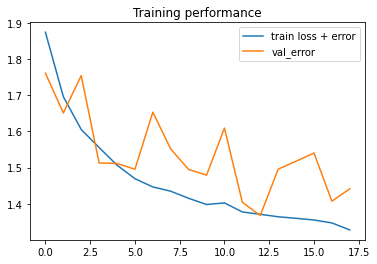

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

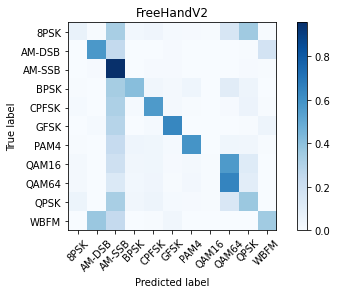

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08135215453194651


Overall Accuracy:  0.09242144177449169


Overall Accuracy:  0.09437963944856839


Overall Accuracy:  0.10295151089248067


Overall Accuracy:  0.1351156069364162


Overall Accuracy:  0.19763694951664876


Overall Accuracy:  0.32210677176639196


Overall Accuracy:  0.45603197674418605


Overall Accuracy:  0.5133120340788072


Overall Accuracy:  0.6042415528396837


Overall Accuracy:  0.6437908496732027


Overall Accuracy:  0.6779661016949152


Overall Accuracy:  0.6774193548387096


Overall Accuracy:  0.6824626865671641


Overall Accuracy:  0.6750720461095101


Overall Accuracy:  0.6861100984323734


Overall Accuracy:  0.701592002961866


Overall Accuracy:  0.6904851447912749


Overall Accuracy:  0.6919675755342668


Overall Accuracy:  0.678853046594982


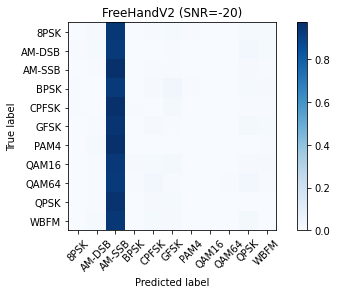

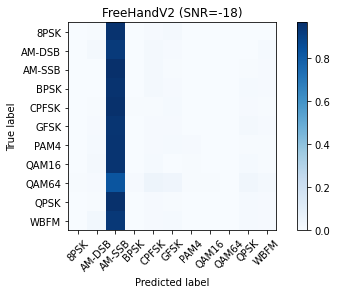

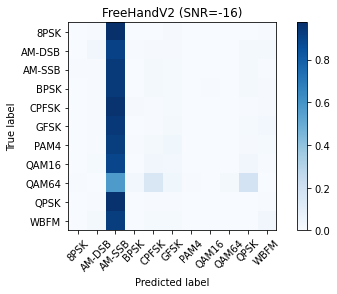

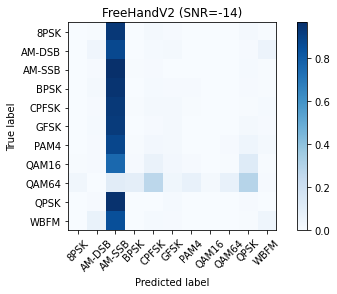

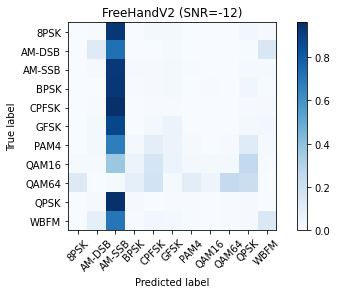

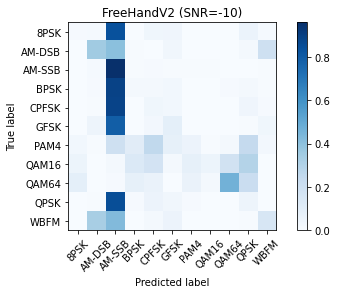

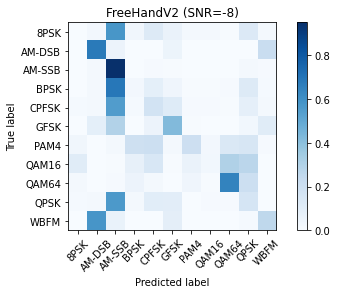

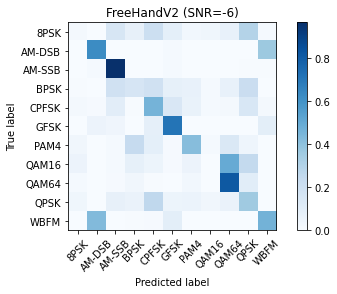

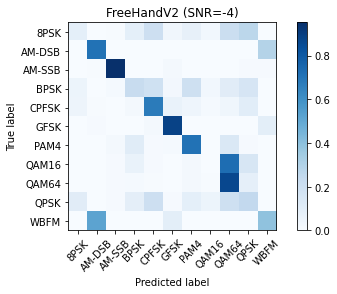

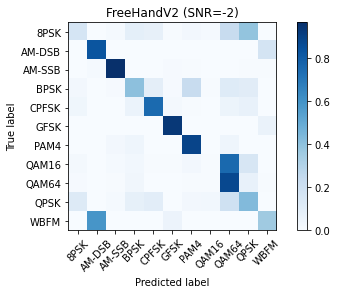

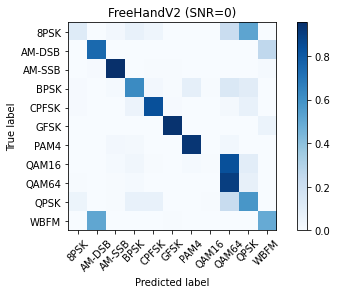

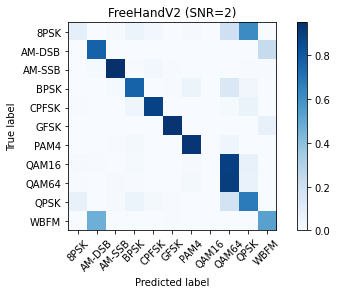

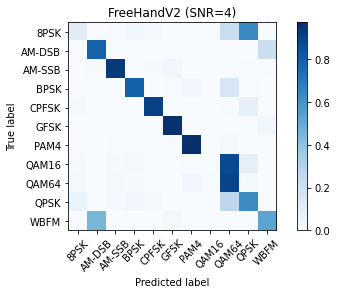

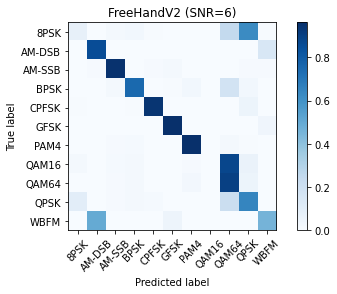

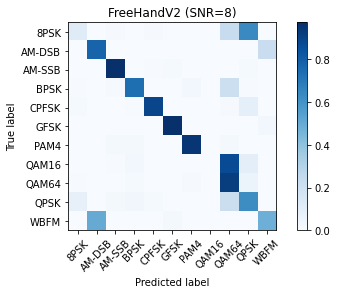

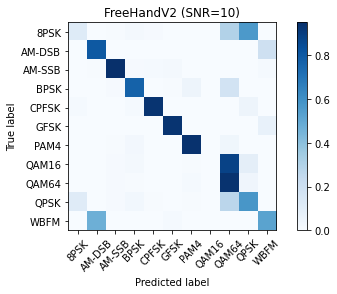

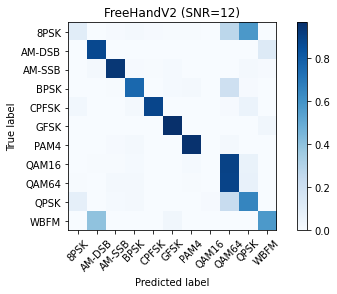

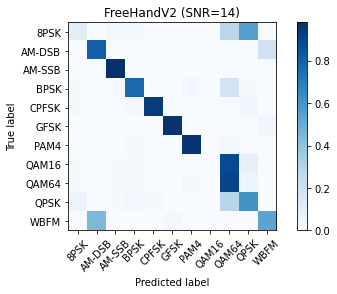

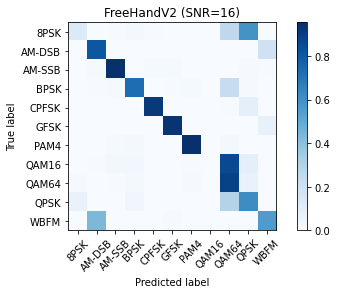

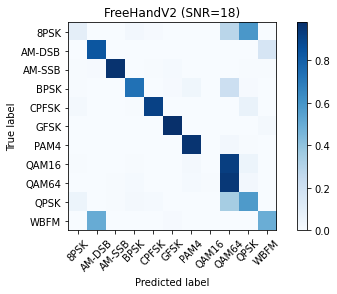

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,13,19,32,45,51,60,64,67,67,68,67,68,70,69,69,67


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

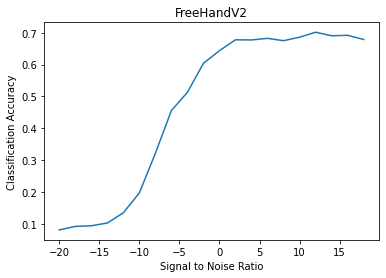

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)